In [ ]:
import numpy as np
import torch
import torch.cuda
import matplotlib.pyplot as plt
from scipy.sparse import identity, kron, csr_matrix, csc_matrix
from scipy.sparse.linalg import expm_multiply
from scipy.integrate import solve_ivp
import pandas as pd
from tqdm import tqdm


In [ ]:
# 5. Enhanced Quantum Evolution with better error handling and GPU support
class QuantumEvolution:
    def __init__(self, atol=1e-8, rtol=1e-8, use_gpu=True):
        self.atol = atol
        self.rtol = rtol
        self.use_gpu = use_gpu and torch.cuda.is_available()
        self.device = torch.device("cuda" if self.use_gpu else "cpu")
        if self.use_gpu:
            print("Using GPU acceleration for quantum evolution")
        else:
            print("Using CPU for quantum evolution")
    
    def evolve_state_torch(self, init_state, hamiltonian_func, t_span, t_eval=None):
        """
        Evolve quantum state using PyTorch on GPU with improved performance
        """
        if t_eval is None:
            t_eval = np.linspace(t_span[0], t_span[1], 100)
        
        # Convert initial state to torch tensor on GPU
        if isinstance(init_state, np.ndarray):
            init_state = init_state.astype(complex)
        
        psi = torch.tensor(init_state, dtype=torch.cfloat, device=self.device)
        
        # Time step size
        dt = (t_span[1] - t_span[0]) / (len(t_eval) - 1)
        
        # Store states at evaluation times (on GPU)
        states = [psi.clone()]
        
        # Runge-Kutta 4th order integrator
        t = t_span[0]
        for i in range(1, len(t_eval)):
            target_t = t_eval[i]
            
            while t < target_t:
                # Get current Hamiltonian
                H_t = hamiltonian_func(t)
                
                # Convert to torch tensor on GPU
                if isinstance(H_t, np.ndarray) or hasattr(H_t, 'toarray'):
                    if hasattr(H_t, 'toarray'):
                        H_t = H_t.toarray()
                    H_t = torch.tensor(H_t, dtype=torch.cfloat, device=self.device)
                
                # RK4 integration
                k1 = -1j * torch.matmul(H_t, psi)
                k2 = -1j * torch.matmul(H_t, psi + 0.5 * dt * k1)
                k3 = -1j * torch.matmul(H_t, psi + 0.5 * dt * k2)
                k4 = -1j * torch.matmul(H_t, psi + dt * k3)
                
                psi = psi + (dt/6) * (k1 + 2*k2 + 2*k3 + k4)
                
                # Normalize state
                norm = torch.norm(psi)
                if norm > 0:
                    psi = psi / norm
                
                t += dt
                
                # Break if we're close enough to target_t
                if abs(t - target_t) < dt/2:
                    break
            
            # Store state on GPU
            states.append(psi.clone())
        
        # Only convert to CPU at the very end
        np_states = []
        for state in states:
            np_states.append(state.cpu().numpy())
        return np.array(np_states)
    
    def evolve_state_ode(self, init_state, hamiltonian_func, t_span, t_eval=None):
        """
        Evolve quantum state using ODE solver with time-dependent Hamiltonian
        Use GPU-accelerated evolution if available, otherwise fall back to scipy
        """
        if self.use_gpu:
            return self.evolve_state_torch(init_state, hamiltonian_func, t_span, t_eval)
        
        # Ensure init_state is a flattened complex array
        if isinstance(init_state, np.ndarray) and init_state.ndim > 1:
            init_state = init_state.flatten()
        init_state = init_state.astype(complex)
        
        # Define Schrödinger equation
        def schrodinger_eq(t, psi):
            H_t = hamiltonian_func(t)
            
            # Convert sparse matrix to dense for multiplication
            if hasattr(H_t, 'toarray'):
                H_t = H_t.toarray()
            
            # Ensure psi is the right shape
            psi = psi.astype(complex)
            
            # Schrödinger equation: i ℏ |dψ/dt⟩ = H |ψ⟩
            # With ℏ = 1: |dψ/dt⟩ = -i H |ψ⟩
            dpsi_dt = -1j * (H_t @ psi)
            
            return dpsi_dt
        
        # Solve ODE
        result = solve_ivp(
            schrodinger_eq,
            t_span,
            init_state,
            t_eval=t_eval,
            method='DOP853',
            atol=self.atol,
            rtol=self.rtol
        )
        
        if not result.success:
            print(f"ODE solver failed: {result.message}")
            return None
        
        # Normalize states and transpose to get (time, state_vector) shape
        states = result.y.T
        for i in range(len(states)):
            norm = np.linalg.norm(states[i])
            if norm > 0:
                states[i] = states[i] / norm
                
        return states


In [ ]:
# 7. Improved QRC with Time-Dependent Hamiltonian and GPU support
class ImprovedQRC:
    def __init__(self, n_sites=10, encoding_type='global', omega_max=2*np.pi*1.5, V=1.0, 
                 duration=3.5, steps=10, atom_distances=None, use_gpu=True):
        self.n_sites = n_sites
        self.encoding_type = encoding_type
        self.omega_max = omega_max
        self.V = V
        self.duration = duration
        self.steps = steps
        self.use_gpu = use_gpu
        
        # Set up atom positions
        if atom_distances is None:
            # Default irregular distances
            atom_distances = [8.3, 8.2, 8.2, 8.2, 8.1, 8.8, 8.2, 8.8, 8.8]
            # Extend if needed or truncate if too many
            if n_sites > len(atom_distances) + 1:
                avg_dist = np.mean(atom_distances)
                atom_distances.extend([avg_dist] * (n_sites - len(atom_distances) - 1))
            elif n_sites < len(atom_distances) + 1:
                atom_distances = atom_distances[:n_sites-1]
                
        self.atoms = generate_irregular_chain(n_sites, atom_distances)
        
        # Initialize quantum evolution with GPU support
        self.evolution = QuantumEvolution(use_gpu=self.use_gpu)
        
        # Initialize readout
        self.readout = EnhancedReadout(n_sites, include_zz=True)


In [ ]:
# 10. Training function with GPU support
def train_qrc_model(X_train, y_train, X_test, y_test, epochs=1000, lr=0.01, use_gpu=True):
    """Train the QRC model"""
    print("Starting training...")
    
    # Check GPU availability
    device = torch.device("cuda" if use_gpu and torch.cuda.is_available() else "cpu")
    print(f"Training on: {device}")
    
    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1).to(device)
    
    # Initialize model and optimizer
    model = LinearReadout(X_train.shape[1]).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.MSELoss()
    
    # Training loop
    train_losses = []
    test_losses = []
    
    for epoch in range(epochs):
        # Forward pass
        y_pred = model(X_train_tensor)
        loss = criterion(y_pred, y_train_tensor)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track losses
        train_losses.append(loss.item())
        
        # Test loss
        with torch.no_grad():
            y_test_pred = model(X_test_tensor)
            test_loss = criterion(y_test_pred, y_test_tensor)
            test_losses.append(test_loss.item())
        
        if epoch % 20 == 0:  # More frequent updates
            print(f'Epoch {epoch}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')
            # Force flush the output
            import sys
            sys.stdout.flush()
    
    return model, train_losses, test_losses


In [ ]:
# 11. Main execution function with GPU support
def run_improved_qrc_experiment(use_gpu=True):
    """Run the complete QRC experiment"""
    # Load data
    data = load_laser_data()
    
    # Prepare time series data
    window = 10
    X, y = prepare_time_series(data, window)
    
    # Split data
    train_size = 1400 - window
    X_train, y_train = X[:train_size], y[:train_size]
    X_test, y_test = X[train_size:], y[train_size:]
    
    # Scale features for encoding
    X_train_scaled = (X_train - np.mean(X_train)) * 9.0
    X_test_scaled = (X_test - np.mean(X_train)) * 9.0
    
    # Initialize improved QRC
    gpu_available = use_gpu and torch.cuda.is_available()
    print(f"Initializing Improved QRC on {'GPU' if gpu_available else 'CPU'}...")
    qrc = ImprovedQRC(
        n_sites=10,
        encoding_type='global',
        omega_max=2*np.pi*1.5,
        V=1.0,
        duration=3.5,
        steps=10,
        use_gpu=use_gpu
    )
    
    # Generate quantum features
    print("Generating quantum features for training data...")
    X_train_quantum = qrc.encode_and_evolve(X_train_scaled)
    print("Generating quantum features for test data...")
    X_test_quantum = qrc.encode_and_evolve(X_test_scaled)
    
    # Train model
    print("Training readout layer...")
    model, train_losses, test_losses = train_qrc_model(
        X_train_quantum, y_train, X_test_quantum, y_test, epochs=500, lr=0.01, use_gpu=use_gpu
    )
    
    # Evaluate and plot results
    device = torch.device("cuda" if use_gpu and torch.cuda.is_available() else "cpu")
    with torch.no_grad():
        y_pred = model(torch.tensor(X_test_quantum, dtype=torch.float32).to(device)).cpu().numpy()
    
    # Calculate NMSE
    test_nmse = np.mean((y_test - y_pred.flatten())**2) / np.var(y_test)
    print(f"Test NMSE: {test_nmse:.6f}")
    
    # Plot results
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Training curves
    plt.subplot(2, 1, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')
    plt.legend()
    
    # Plot 2: Predictions vs Ground Truth
    plt.subplot(2, 1, 2)
    plt.plot(y_test[50:150], label='Ground Truth')
    plt.plot(y_pred.flatten()[50:150], label='Improved QRC Prediction')
    plt.xlabel('Time')
    plt.ylabel('Laser Intensity')
    plt.title('Improved QRC Prediction vs Ground Truth')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return model, qrc, X_train_quantum, X_test_quantum, y_test, y_pred


In [ ]:
# Example usage
if __name__ == "__main__":
    # Check GPU availability
    use_gpu = torch.cuda.is_available()
    if use_gpu:
        print("GPU is available! Using CUDA for acceleration.")
    else:
        print("GPU not available. Running on CPU.")
    
    # Run the improved QRC experiment with GPU support
    model, qrc, X_train_quantum, X_test_quantum, y_test, y_pred = run_improved_qrc_experiment(use_gpu=use_gpu)
    
    # Load data for classical baselines
    data = load_laser_data()
    window = 10
    X, y = prepare_time_series(data, window)
    train_size = 1400 - window
    X_train, y_train = X[:train_size], y[:train_size]
    X_test, y_test = X[train_size:], y[train_size:]
    
    # Run classical baselines for comparison with reduced epochs
    print("Running classical baselines for comparison...")
    linear_model, nn_model, linear_pred, nn_pred = run_classical_baselines(X_train, y_train, X_test, y_test)


In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.sparse import identity, kron, csr_matrix, csc_matrix
from scipy.sparse.linalg import expm_multiply, expm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import pandas as pd

# 1. Hamiltonian Implementation
class Rydberg:
    def __init__(self, n_sites, omega, V, detuning_values=None):
        self.n_sites = n_sites
        self.omega = omega
        self.V = V  # Interaction parameter
        self.I = csr_matrix(np.eye(2))  # Identity matrix (sparse)
        self.sigma_x = csr_matrix(np.array([[0, 1], [1, 0]]))
        self.sigma_z = csr_matrix(np.array([[1, 0], [0, -1]]))
        
        if detuning_values is None:
            self.detuning_values = np.zeros(n_sites)
        else:
            if len(detuning_values) != n_sites:
                raise ValueError("detuning_values must match the number of qubits")
            self.detuning_values = np.array(detuning_values)

    def construct_operator(self, op, qubits):
        n = self.n_sites
        full_operator = identity(1, format="csr")  # Start with identity
        
        for i in range(n):
            if i in qubits:
                full_operator = kron(full_operator, op, format="csr")
            else:
                full_operator = kron(full_operator, self.I, format="csr")
        
        return full_operator

    def construct_hamiltonian(self):
        """Builds the full Hamiltonian for the system, supporting array-valued omega."""
        H = csr_matrix((2**self.n_sites, 2**self.n_sites), dtype=complex)

        # Check if omega is array-like (from local_encode)
        if isinstance(self.omega, (list, np.ndarray)):
            # Apply site-specific omega values
            if len(self.omega) != self.n_sites:
                raise ValueError(f"Expected {self.n_sites} omega values, got {len(self.omega)}")
                
            for i in range(self.n_sites):
                H += self.omega[i] * self.construct_operator(self.sigma_x, [i])
        else:
            # Apply same omega to all sites
            for i in range(self.n_sites):
                H += self.omega * self.construct_operator(self.sigma_x, [i])
        
        # Apply detuning and interaction terms
        for i in range(self.n_sites):
            H += self.detuning_values[i] * self.construct_operator(self.sigma_z, [i])
            
            # Add ZZ interactions between all pairs with distance-dependent interaction strength
            for j in range(i+1, self.n_sites):
                # Distance-dependent interaction strength (~ 1/r^3 for better feature generation)
                interaction_strength = self.V / ((j - i) ** 2 + 1)
                H += interaction_strength * self.construct_operator(self.sigma_z, [i, j])

        return H.toarray()

# 2. Encodings
class LocalEncode:
    def __init__(self, n_sites, dimension=1, base_omega=1.0, encoding_scale=0.5):
        self.n_sites = n_sites
        self.dimension = dimension
        self.base_omega = base_omega
        self.encoding_scale = encoding_scale
        self.max_features = 2**n_sites

    def encode(self, data):
        n_samples = data.shape[0]
        n_features = data.shape[1]
        initial_states = []
        hamil_params = []
        
        for i in range(n_samples):
            # Creating superposition initial state for better quantum advantage
            state = np.zeros(self.max_features, dtype=complex)
            state[0] = 1/np.sqrt(2)  # |0...0⟩
            state[1] = 1/np.sqrt(2)  # |0...01⟩ (first qubit in superposition)
            initial_states.append(state)

            sample = data[i]
            omega_values = np.ones(self.n_sites) * self.base_omega  # For Rabi frequency
            detuning_values = np.zeros(self.n_sites)

            # Nonlinear encoding of features to all parameters
            for j in range(self.n_sites):
                if j < n_features:
                    # Nonlinear encoding for more expressive power
                    omega_values[j] = self.base_omega * (1.0 + np.sin(np.pi * self.encoding_scale * sample[j]))
                    detuning_values[j] = self.encoding_scale * np.cos(np.pi * sample[j % n_features])
                else:
                    # For indices beyond the feature length, use cyclic feature mapping
                    feature_idx = j % n_features
                    omega_values[j] = self.base_omega * (1.0 + np.sin(np.pi * self.encoding_scale * sample[feature_idx]))
                    detuning_values[j] = self.encoding_scale * np.cos(np.pi * sample[feature_idx])
            
            params = {
                'omega': omega_values,
                'detuning_values': detuning_values,
                'V': 2.0  # Stronger interaction strength for better nonlinear processing
            }
            hamil_params.append(params)
            
        return np.array(initial_states), hamil_params

class GlobalEncode:
    def __init__(self, n_sites, encoding_type='hamiltonian', base_omega=1.2, base_V=1.2, 
                 detuning_scale=0.5, param_scale=0.5):
        self.n_sites = n_sites
        self.encoding_type = encoding_type
        self.base_omega = base_omega
        self.base_V = base_V
        self.detuning_scale = detuning_scale
        self.param_scale = param_scale
        self.max_features = 2**n_sites
    
    def encode(self, data):
        n_data = data.shape[0]

        initial_states = np.zeros((n_data, self.max_features), dtype=complex)
        initial_states[:, 0] = 1.0

        hamiltonian_params = []

        if self.encoding_type == 'hamiltonian':
            for sample in data:
                n_features = len(sample)
                if n_features >= 2:  # Base conditions
                    omega = self.base_omega + self.param_scale * sample[0]
                    V = self.base_V + self.param_scale * sample[1]
                else:
                    omega = self.base_omega
                    V = self.base_V
                
                detuning_values = np.zeros(self.n_sites)
                for i in range(min(n_features - 2, self.n_sites)):
                    if i + 2 < n_features:
                        detuning_values[i] = self.detuning_scale * sample[i + 2]

                hamiltonian_params.append({
                    'omega': omega,
                    'V': V,
                    'detuning_values': detuning_values
                })
        elif self.encoding_type == 'detuning':
            for sample in data:
                detuning_values = np.zeros(self.n_sites)
                for i in range(min(len(sample), self.n_sites)):
                    detuning_values[i] = self.detuning_scale * sample[i]
                
                hamiltonian_params.append({
                    'omega': self.base_omega,
                    'V': self.base_V,
                    'detuning_values': detuning_values
                })
        else:
            raise ValueError(f"Unknown encoding type: {self.encoding_type}")
            
        return initial_states, hamiltonian_params

# 3. Solver
class BloqadeSolver:
    def with_initial_state(self, state_vector, num_qubits):
        # Ensure the state is a NumPy array
        state_vector = np.array(state_vector, dtype=complex)

        # Check if the provided state vector has the correct length
        expected_size = 2 ** num_qubits
        if state_vector.size != expected_size:
            raise ValueError(f"State vector must have {expected_size} elements.")

        # Normalize the state vector
        norm = np.linalg.norm(state_vector)
        if norm == 0:
            raise ValueError("State vector cannot be all zeros.")
        state_vector /= norm

        return state_vector
 
    def evolve_state(self, init_state, hamiltonian, duration, steps):
        dt = duration / steps
        state = init_state
        
        # Use expm_multiply for sparse matrix evolution
        if isinstance(hamiltonian, csr_matrix):
            for _ in range(steps):
                # Evolve state using the sparse matrix exponential without forming full matrix
                state = expm_multiply(-1j * dt * hamiltonian, state)
        else:
            # Fall back to dense matrix evolution if Hamiltonian is not sparse
            U = expm(-1j * hamiltonian * dt)
            for _ in range(steps):
                state = U @ state
                
        return state
    
    def simulate(self, init_state, hamiltonian, duration, steps, n_qubits, return_all_steps=False):
        """
        Simulate quantum evolution with option to return all intermediate states.
        
        Args:
            init_state: Initial quantum state vector
            hamiltonian: Hamiltonian operator as sparse or dense matrix
            duration: Total evolution time
            steps: Number of time steps
            n_qubits: Number of qubits
            return_all_steps: If True, returns states at all time steps
                            If False, returns only the final state
        """
        new_state = self.with_initial_state(init_state, n_qubits)
        dt = duration / steps
        
        if return_all_steps:
            # Initialize list to store states at each time step
            all_states = [new_state.copy()]  # Include initial state
            
            # Convert hamiltonian to sparse if it's not already
            if not isinstance(hamiltonian, csr_matrix):
                hamiltonian = csr_matrix(hamiltonian)
                
            # Use expm_multiply for sparse matrix evolution
            state = new_state
            for step in range(steps):
                # Evolve state using the sparse matrix exponential
                state = expm_multiply(-1j * dt * hamiltonian, state)
                all_states.append(state.copy())
            
            return all_states
        else:
            # Original behavior: return only final state
            state = new_state
            
            # Convert hamiltonian to sparse if it's not already
            if not isinstance(hamiltonian, csr_matrix):
                hamiltonian = csr_matrix(hamiltonian)
                
            for _ in range(steps):
                state = expm_multiply(-1j * dt * hamiltonian, state)
            
            return state

# 4. Readouts
def construct_pauli_z(qubit_index, num_qubits):
    z_sparse = csc_matrix(([1, -1], ([0, 1], [0, 1])), shape=(2, 2))  # Single qubit Pauli Z matrix
    identity_left = identity(2**qubit_index, format="csc")
    identity_right = identity(2**(num_qubits - qubit_index - 1), format="csc")  # Embedding into full Hilbert space
    return kron(identity_left, kron(z_sparse, identity_right), format="csc")

def construct_pauli_zz(qubit_i, qubit_j, num_qubits):
    # ZZ correlation is just the tensor product of Z_i and Z_j
    z_i = construct_pauli_z(qubit_i, num_qubits)
    z_j = construct_pauli_z(qubit_j, num_qubits)
    return z_i @ z_j  # Matrix multiplication of sparse matrices

def expectation(state, operator):
    op_state = operator @ state
    return np.real(np.vdot(state, op_state))  # Inner product

def z_expectation(state, qubit_index, num_qubits):
    pauli_z_op = construct_pauli_z(qubit_index, num_qubits)
    return expectation(state, pauli_z_op)

def zz_expectation(state, qubit_i, qubit_j, num_qubits):
    pauli_zz_op = construct_pauli_zz(qubit_i, qubit_j, num_qubits)
    return expectation(state, pauli_zz_op)

def construct_pauli_x(qubit_index, num_qubits):
    x_sparse = csc_matrix(([1, 1], ([0, 1], [1, 0])), shape=(2, 2))
    identity_left = identity(2**qubit_index, format="csc")
    identity_right = identity(2**(num_qubits - qubit_index - 1), format="csc")
    return kron(identity_left, kron(x_sparse, identity_right), format="csc")

def construct_pauli_y(qubit_index, num_qubits):
    y_sparse = csc_matrix(([1j, -1j], ([0, 1], [1, 0])), shape=(2, 2), dtype=complex)
    identity_left = identity(2**qubit_index, format="csc")
    identity_right = identity(2**(num_qubits - qubit_index - 1), format="csc")
    return kron(identity_left, kron(y_sparse, identity_right), format="csc")

def construct_pauli_xy(qubit_i, qubit_j, num_qubits):
    # XY correlation
    x_i = construct_pauli_x(qubit_i, num_qubits)
    y_j = construct_pauli_y(qubit_j, num_qubits)
    return x_i @ y_j

def x_expectation(state, qubit_index, num_qubits):
    pauli_x_op = construct_pauli_x(qubit_index, num_qubits)
    return expectation(state, pauli_x_op)

def y_expectation(state, qubit_index, num_qubits):
    pauli_y_op = construct_pauli_y(qubit_index, num_qubits)
    return expectation(state, pauli_y_op)

def xy_expectation(state, qubit_i, qubit_j, num_qubits):
    pauli_xy_op = construct_pauli_xy(qubit_i, qubit_j, num_qubits)
    return expectation(state, pauli_xy_op)

class EnhancedReadout:
    def __init__(self, n_sites, readout_indices=None, correlation_pairs=None, 
                 time_points=None, include_multiple_observables=True, include_multi_time=True):
        self.n_sites = n_sites
        self.readout_indices = readout_indices if readout_indices is not None else list(range(n_sites))
        self.include_multiple_observables = include_multiple_observables
        self.include_multi_time = include_multi_time
        self.time_points = time_points if time_points is not None else [0, 2, 4, 6, 8]  # Multiple time steps for temporal features
        
        # Default correlation pairs: more comprehensive correlations
        if correlation_pairs is None and include_multiple_observables:
            self.correlation_pairs = []
            # Include both nearest neighbors and some longer-range correlations
            for i in range(n_sites):
                for j in range(i+1, n_sites):
                    if j - i <= 3:  # Limit to reasonable range interactions
                        self.correlation_pairs.append((i, j))
        else:
            self.correlation_pairs = correlation_pairs if correlation_pairs else []
            
    def measure_single_state(self, state, num_qubits):
        features = []
        # Measure all Pauli observables for richer feature set
        for idx in self.readout_indices:
            features.append(z_expectation(state, idx, num_qubits))
            
            if self.include_multiple_observables:
                features.append(x_expectation(state, idx, num_qubits))
                features.append(y_expectation(state, idx, num_qubits))
            
        # Measure correlations if enabled
        if self.include_multiple_observables:
            for i, j in self.correlation_pairs:
                features.append(zz_expectation(state, i, j, num_qubits))
                features.append(xy_expectation(state, i, j, num_qubits))
                
        return features
        
    def measure(self, evolved_results, num_qubits):
        features = []
        
        for state_history in evolved_results:
            sample_features = []
            
            if self.include_multi_time and self.time_points is not None:
                # Measure at specific time points
                for time_index in self.time_points:
                    if time_index < len(state_history):
                        # Get state at this time point
                        state = state_history[time_index]
                        sample_features.extend(self.measure_single_state(state, num_qubits))
                    else:
                        # This time point doesn't exist in the history
                        padding_size = len(self.readout_indices)
                        if self.include_multiple_observables:
                            padding_size *= 3  # For X, Y, Z measurements
                            padding_size += len(self.correlation_pairs) * 2  # For ZZ and XY correlations
                        sample_features.extend([0] * padding_size)
            else:
                # Just use the final state
                final_state = state_history[-1]
                sample_features.extend(self.measure_single_state(final_state, num_qubits))
                
            features.append(sample_features)
            
        return np.array(features)

# 5. QRC class to integrate everything
class QuantumReservoirComputer:
    def __init__(self, n_sites=8, encoding_type='local', omega=2.5, V=3.0, 
                 duration=5.0, steps=20):
        self.n_sites = n_sites
        self.encoding_type = encoding_type
        self.duration = duration
        self.steps = steps
        
        # Initialize components with improved parameters
        if encoding_type == 'local':
            self.encoder = LocalEncode(n_sites, base_omega=omega, encoding_scale=1.0)
        else:
            self.encoder = GlobalEncode(n_sites, encoding_type='hamiltonian', 
                                       base_omega=omega, base_V=V, detuning_scale=1.0)
        
        self.solver = BloqadeSolver()
        # Enhanced readout with multiple observables and time points
        self.readout = EnhancedReadout(n_sites, include_multiple_observables=True, include_multi_time=True)
    
    def encode_and_evolve(self, X):
        # Encode classical data
        initial_states, hamil_params = self.encoder.encode(X)
        
        # Evolve quantum states
        evolved_states = []
        for i in range(len(X)):
            hamiltonian = Rydberg(
                self.n_sites, 
                hamil_params[i]['omega'],
                hamil_params[i]['V'],
                hamil_params[i]['detuning_values']
            ).construct_hamiltonian()
            
            # Simulate quantum evolution
            states = self.solver.simulate(
                initial_states[i],
                hamiltonian,
                self.duration,
                self.steps,
                self.n_sites,
                return_all_steps=True
            )
            evolved_states.append(states)
        
        # Measure observables
        features = self.readout.measure(evolved_states, self.n_sites)
        return features

# 6. Linear readout layer (using PyTorch)
class LinearReadout(torch.nn.Module):
    def __init__(self, input_size):
        super(LinearReadout, self).__init__()
        self.linear = torch.nn.Linear(input_size, 1)
    
    def forward(self, x):
        return self.linear(x)

# 7. Data loading and preparation
def load_laser_data(path=None):
    if path is not None:
        try:
            df = pd.read_csv(path)
            return df["laser"].values / 255.0  # Normalize like in Julia code
        except:
            print(f"Could not load data from {path}, generating synthetic data instead.")
    
    # Generate synthetic data similar to the example
    t = np.linspace(0, 10, 2000)
    data = 0.5 + 0.3 * np.sin(t) + 0.1 * np.sin(2.5*t) + 0.05 * np.random.randn(2000)
    return data / np.max(data)  # Normalize to [0,1] range

def prepare_time_series(data, window=10):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

# 8. Training function
def train_qrc_model(X_train, y_train, X_test, y_test, epochs=2000, lr=0.005):
    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)
    
    # Initialize model and optimizer
    model = LinearReadout(X_train.shape[1])
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)  # Added weight decay for regularization
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=100, factor=0.5, verbose=True)
    criterion = torch.nn.MSELoss()
    
    # Training loop
    train_losses = []
    test_losses = []
    best_test_loss = float('inf')
    best_model_state = None
    
    for epoch in range(epochs):
        # Forward pass
        y_pred = model(X_train_tensor)
        loss = criterion(y_pred, y_train_tensor)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        # Track losses
        train_losses.append(loss.item())
        
        # Test loss
        with torch.no_grad():
            y_test_pred = model(X_test_tensor)
            test_loss = criterion(y_test_pred, y_test_tensor)
            test_losses.append(test_loss.item())
        
        # Save best model
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            best_model_state = {key: val.clone() for key, val in model.state_dict().items()}
        
        # Step the scheduler
        scheduler.step(test_loss)
        
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')
    
    # Restore best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model, train_losses, test_losses

# 9. Main execution
def run_qrc_experiment():
    # Load data
    data = load_laser_data()
    
    # Prepare time series data
    window = 10
    X, y = prepare_time_series(data, window)
    
    # Split data
    train_size = 1400 - window
    X_train, y_train = X[:train_size], y[:train_size]
    X_test, y_test = X[train_size:], y[train_size:]
    
    # Improved scaling: Use MinMaxScaler for better quantum feature encoding
    scaler = MinMaxScaler(feature_range=(-1, 1))
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Initialize QRC with improved parameters
    print("Initializing QRC...")
    qrc = QuantumReservoirComputer(
        n_sites=6,  # More qubits for better expressivity
        encoding_type='local',
        omega=2.5,  # Higher Rabi frequency
        V=3.0,      # Stronger interaction
        duration=5.0, # Longer evolution time
        steps=20     # More time steps for better resolution
    )
    
    # Generate quantum features
    print("Generating quantum features for training data...")
    X_train_quantum = qrc.encode_and_evolve(X_train_scaled)
    print("Generating quantum features for test data...")
    X_test_quantum = qrc.encode_and_evolve(X_test_scaled)
    
    # Print feature dimensionality to see the effect of enhanced readout
    print(f"Quantum feature dimensionality: {X_train_quantum.shape[1]}")
    
    # Train model with more epochs and improved learning rate
    print("Training readout layer...")
    model, train_losses, test_losses = train_qrc_model(
        X_train_quantum, y_train, X_test_quantum, y_test, epochs=2000, lr=0.005
    )
    
    # Evaluate and plot results
    with torch.no_grad():
        y_pred = model(torch.tensor(X_test_quantum, dtype=torch.float32)).numpy()
    
    # Calculate NMSE
    test_nmse = np.mean((y_test - y_pred.flatten())**2) / np.var(y_test)
    print(f"Test NMSE: {test_nmse:.6f}")
    
    # Plot results
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Training curves
    plt.subplot(2, 1, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')
    plt.legend()
    
    # Plot 2: Predictions vs Ground Truth
    plt.subplot(2, 1, 2)
    plt.plot(y_test[50:150], label='Ground Truth')
    plt.plot(y_pred.flatten()[50:150], label='QRC Prediction')
    plt.xlabel('Time')
    plt.ylabel('Laser Intensity')
    plt.title('QRC Prediction vs Ground Truth')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return model, qrc, X_train_quantum, X_test_quantum, y_test, y_pred

Initializing QRC...
Generating quantum features for training data...
Generating quantum features for test data...
Training readout layer...
Epoch 0, Train Loss: 0.3729, Test Loss: 0.4523
Epoch 100, Train Loss: 0.0404, Test Loss: 0.0680
Epoch 200, Train Loss: 0.0285, Test Loss: 0.0524
Epoch 300, Train Loss: 0.0226, Test Loss: 0.0431
Epoch 400, Train Loss: 0.0199, Test Loss: 0.0381
Epoch 500, Train Loss: 0.0189, Test Loss: 0.0358
Epoch 600, Train Loss: 0.0186, Test Loss: 0.0349
Epoch 700, Train Loss: 0.0185, Test Loss: 0.0345
Epoch 800, Train Loss: 0.0185, Test Loss: 0.0343
Epoch 900, Train Loss: 0.0185, Test Loss: 0.0343
Test NMSE: 0.905247


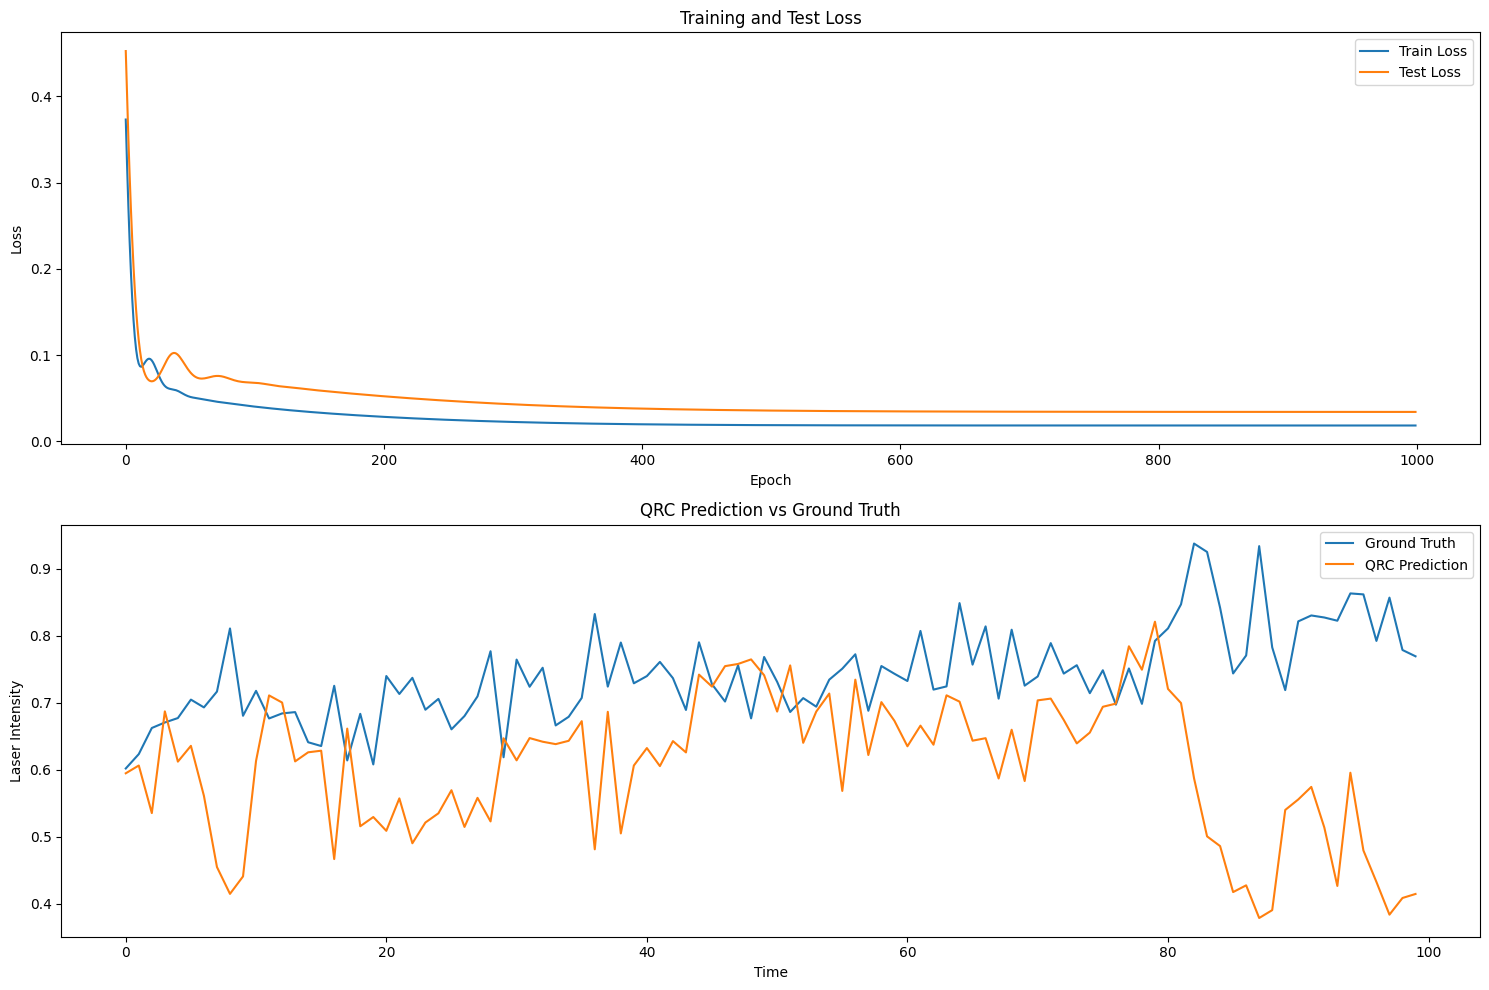

In [2]:
model, qrc, X_train_quantum, X_test_quantum, y_test, y_pred = run_pennylane_qrc_experiment()

In [3]:
def run_classical_baselines(X_train, y_train, X_test, y_test):
    # Linear model
    linear_model = LinearReadout(X_train.shape[1])
    linear_optimizer = torch.optim.Adam(linear_model.parameters(), lr=0.01)
    criterion = torch.nn.MSELoss()
    
    # Train linear model
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)
    
    for epoch in range(1000):
        y_pred = linear_model(X_train_tensor)
        loss = criterion(y_pred, y_train_tensor)
        
        linear_optimizer.zero_grad()
        loss.backward()
        linear_optimizer.step()
        
        if epoch % 200 == 0:
            print(f'Linear Model Epoch {epoch}, Loss: {loss.item():.6f}')
    
    # Neural Network model
    nn_model = torch.nn.Sequential(
        torch.nn.Linear(X_train.shape[1], 50),
        torch.nn.ReLU(),
        torch.nn.Linear(50, 50),
        torch.nn.ReLU(),
        torch.nn.Linear(50, 1)
    )
    nn_optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.004)
    
    # Train NN model
    for epoch in range(1000):
        y_pred = nn_model(X_train_tensor)
        loss = criterion(y_pred, y_train_tensor)
        
        nn_optimizer.zero_grad()
        loss.backward()
        nn_optimizer.step()
        
        if epoch % 200 == 0:
            print(f'NN Model Epoch {epoch}, Loss: {loss.item():.6f}')
    
    # Evaluate both models
    with torch.no_grad():
        linear_pred = linear_model(X_test_tensor).numpy()
        nn_pred = nn_model(X_test_tensor).numpy()
    
    # Calculate NMSE
    linear_nmse = np.mean((y_test - linear_pred.flatten())**2) / np.var(y_test)
    nn_nmse = np.mean((y_test - nn_pred.flatten())**2) / np.var(y_test)
    
    print(f"Linear Model Test NMSE: {linear_nmse:.6f}")
    print(f"Neural Network Test NMSE: {nn_nmse:.6f}")
    
    # Plot results
    plt.figure(figsize=(15, 5))
    plt.plot(y_test, label='Ground Truth')
    plt.plot(linear_pred.flatten(), label='Linear Model')
    plt.plot(nn_pred.flatten(), label='Neural Network')
    plt.xlabel('Time')
    plt.ylabel('Laser Intensity')
    plt.title('Classical Models Predictions vs Ground Truth')
    plt.legend()
    plt.show()
    
    return linear_model, nn_model, linear_pred, nn_pred

Initializing QRC...
Generating quantum features for training data...
Generating quantum features for test data...
Training readout layer...
Epoch 0, Train Loss: 0.7343, Test Loss: 0.8326
Epoch 100, Train Loss: 0.0591, Test Loss: 0.0843
Epoch 200, Train Loss: 0.0382, Test Loss: 0.0663
Epoch 300, Train Loss: 0.0297, Test Loss: 0.0554
Epoch 400, Train Loss: 0.0249, Test Loss: 0.0474
Epoch 500, Train Loss: 0.0224, Test Loss: 0.0422
Epoch 600, Train Loss: 0.0213, Test Loss: 0.0391
Epoch 700, Train Loss: 0.0208, Test Loss: 0.0373
Epoch 800, Train Loss: 0.0206, Test Loss: 0.0364
Epoch 900, Train Loss: 0.0205, Test Loss: 0.0359
Test NMSE: 0.874617


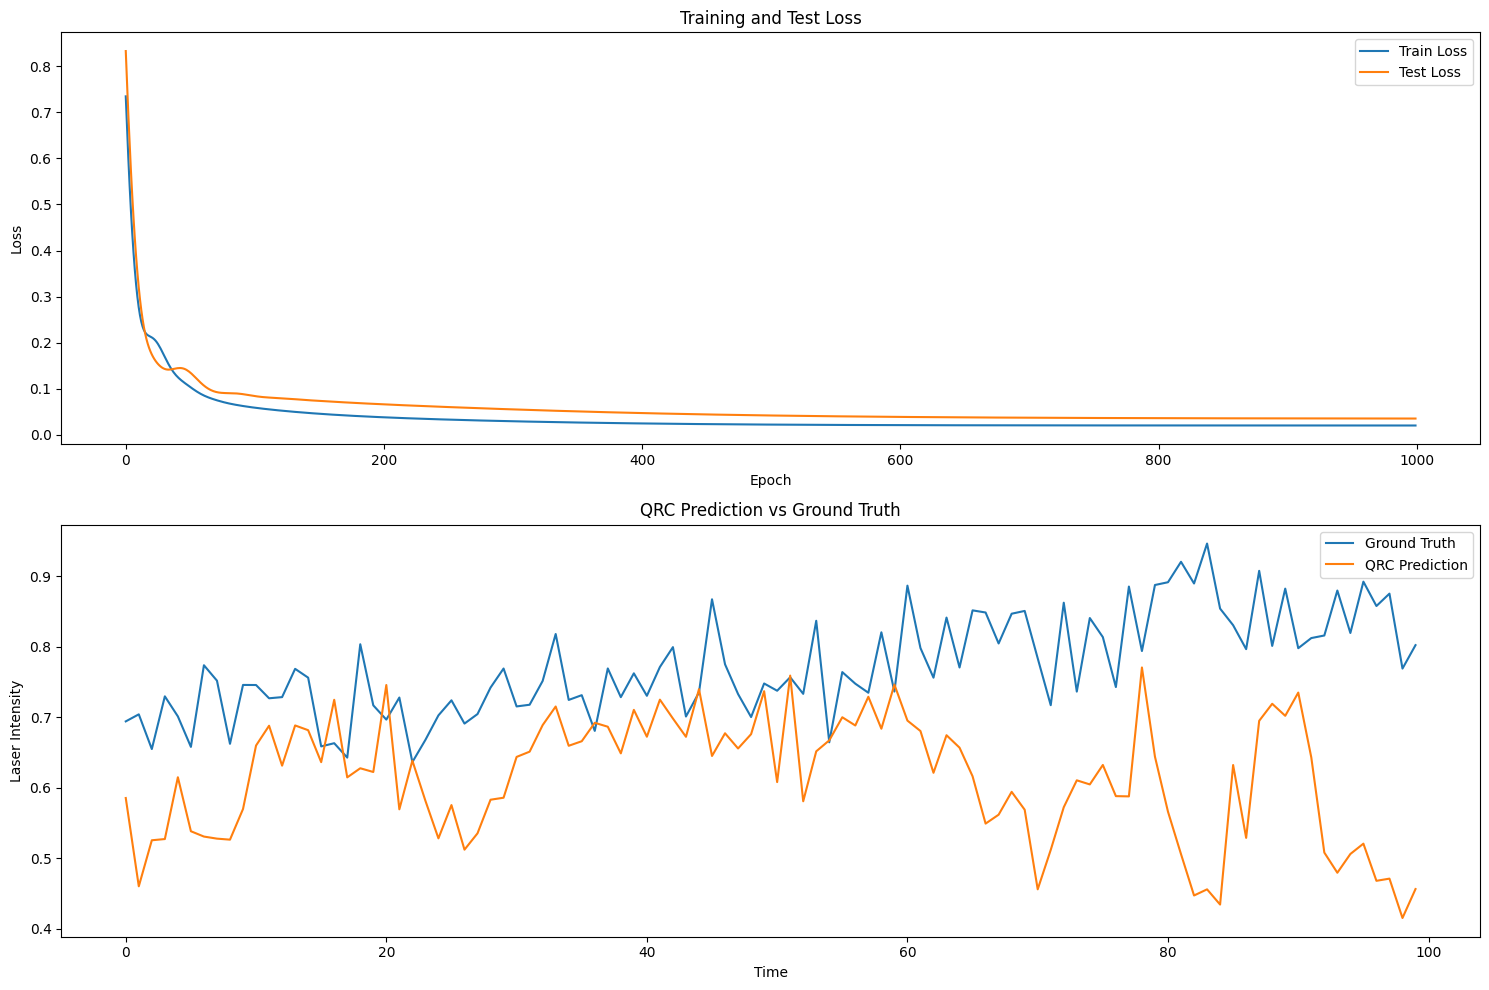

Linear Model Epoch 0, Loss: 0.800108
Linear Model Epoch 500, Loss: 0.003934
Linear Model Epoch 1000, Loss: 0.003373
Linear Model Epoch 1500, Loss: 0.003045
Linear Model Epoch 2000, Loss: 0.002924
Linear Model Epoch 2500, Loss: 0.002896
NN Model Epoch 0, Loss: 0.264241
NN Model Epoch 500, Loss: 0.002826
NN Model Epoch 1000, Loss: 0.002768
NN Model Epoch 1500, Loss: 0.002671
NN Model Epoch 2000, Loss: 0.002612
NN Model Epoch 2500, Loss: 0.002407
NN Model Epoch 3000, Loss: 0.002263
NN Model Epoch 3500, Loss: 0.002185
NN Model Epoch 4000, Loss: 0.002113
NN Model Epoch 4500, Loss: 0.002057
Linear Model Test NMSE: 0.073150
Neural Network Test NMSE: 0.083967


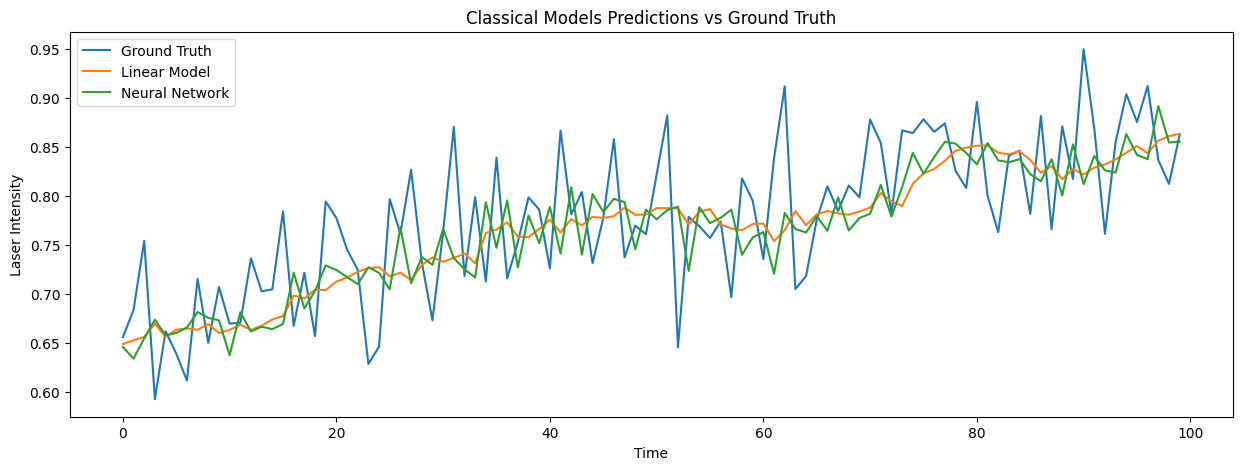

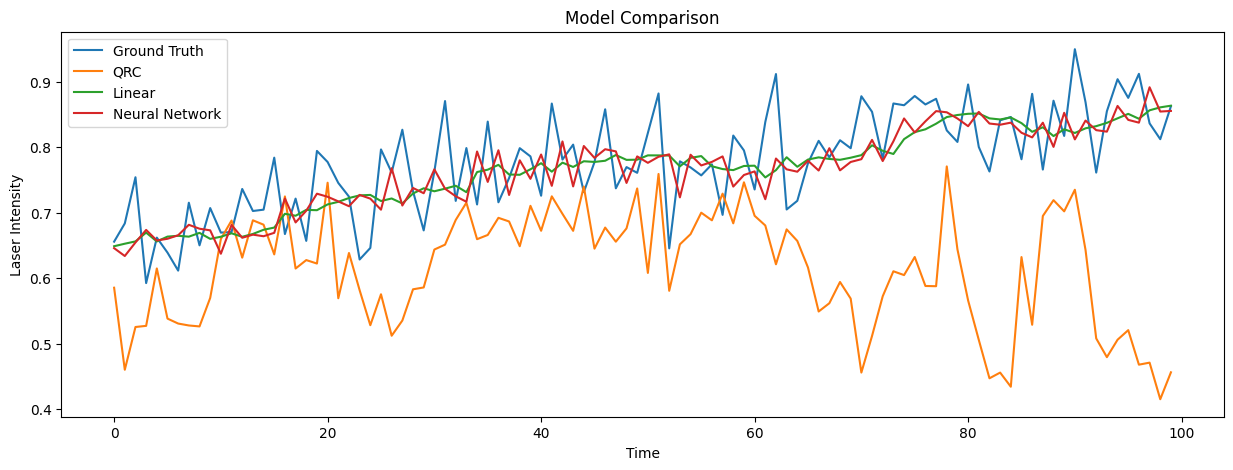

In [6]:
# First run the PennyLane QRC experiment
model, qrc, X_train_quantum, X_test_quantum, y_test_qrc, y_pred = run_pennylane_qrc_experiment()

# Then get the original data for classical baselines
data = load_laser_data()
window = 10
X, y = prepare_time_series(data, window)
train_size = 1400 - window
X_train, y_train = X[:train_size], y[:train_size]

# For fair comparison, use the same test samples as the quantum model
test_sample_size = len(y_test_qrc)
X_test = X[train_size:train_size+test_sample_size]
y_test = y[train_size:train_size+test_sample_size]

# Run classical baselines
linear_model, nn_model, linear_pred, nn_pred = run_classical_baselines(X_train[:100], y_train[:100], X_test, y_test)

# Compare all models
plt.figure(figsize=(15, 5))
plt.plot(y_test, label='Ground Truth')
plt.plot(y_pred.flatten(), label='PennyLane QRC')
plt.plot(linear_pred.flatten(), label='Linear')
plt.plot(nn_pred.flatten(), label='Neural Network')
plt.xlabel('Time')
plt.ylabel('Laser Intensity')
plt.title('Model Comparison')
plt.legend()
plt.show()

In [8]:

import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.sparse import identity, kron, csr_matrix, csc_matrix
from scipy.sparse.linalg import expm_multiply
from scipy.integrate import solve_ivp
import pandas as pd
from tqdm import tqdm

# 1. Atom Positioning with Irregular Spacing
class AtomList:
    def __init__(self, positions):
        """
        positions: List of (x, y) tuples for atom positions
        """
        self.positions = np.array(positions)
        self.n_atoms = len(positions)
        
    def distances(self):
        """Calculate pairwise distances between atoms"""
        #simple eucledian formula here using numpy
        dist_matrix = np.zeros((self.n_atoms, self.n_atoms))
        for i in range(self.n_atoms): #calculate upper traingle value and copy it lower triangle
            for j in range(i+1, self.n_atoms):
                dist = np.sqrt(np.sum((self.positions[i] - self.positions[j])**2))
                dist_matrix[i, j] = dist
                dist_matrix[j, i] = dist
        return dist_matrix

def generate_chain_lattice(n_sites, scale=10.0):
    #Generate a 1D chain of atoms with uniform spacing-> aka ur regular ol perfect chain
    return AtomList([(0, i*scale) for i in range(n_sites)])

def generate_irregular_chain(n_sites, distances):
    """
    Generate a 1D chain with irregular spacing
    distances: List of n_sites-1 distances between adjacent atoms
    """
    if len(distances) != n_sites - 1:
        raise ValueError("Need n_sites-1 distances for n_sites atoms")
        
    positions = [(0, 0)]
    y_pos = 0
    for d in distances:
        y_pos += d
        positions.append((0, y_pos))
        
    return AtomList(positions)

# 2. Time-Dependent Pulse Shaping
class PiecewiseLinear:
    #this is  for smooth(slopy) ramp up/down
    def __init__(self, clocks, values):
        """
        Define a piecewise linear function
        clocks: List of time points
        values: Function values at those time points
        """

        if len(clocks) != len(values):
            raise ValueError("clocks and values must have same length")
            
        self.clocks = np.array(clocks)
        self.values = np.array(values)
        
    def __call__(self, t):
        """Evaluate function at time t"""
        if t <= self.clocks[0]:
            return self.values[0]
        if t >= self.clocks[-1]:
            return self.values[-1]
            
        # Find the appropriate segment
        idx = np.searchsorted(self.clocks, t) - 1
        t0, t1 = self.clocks[idx], self.clocks[idx+1]
        v0, v1 = self.values[idx], self.values[idx+1]
        
        # Linear interpolation
        alpha = (t - t0) / (t1 - t0)
        return v0 + alpha * (v1 - v0)

class PiecewiseConstant:
    #this si staicase typa ramp up and down
    def __init__(self, clocks, values):
        """
        Define a piecewise constant function
        clocks: List of time points where function changes
        values: Function values for each interval
        """
        if len(clocks) != len(values) + 1:
            raise ValueError("For piecewise constant, need len(clocks) = len(values) + 1")
            
        self.clocks = np.array(clocks)
        self.values = np.array(values)
        
    def __call__(self, t):
        """Evaluate function at time t"""
        idx = np.searchsorted(self.clocks, t) - 1
        if idx < 0:
            return self.values[0]
        if idx >= len(self.values):
            return self.values[-1]
        return self.values[idx]

# 3. Operators for Quantum Evolution
def construct_operator(op, qubits, n_sites):
    """Construct operator acting on specific qubits in the full Hilbert space"""
    I = csr_matrix(np.eye(2))  # Identity matrix
    full_operator = identity(1, format="csr")  # Start with identity
    
    for i in range(n_sites):
        if i in qubits:
            full_operator = kron(full_operator, op, format="csr")
        else:
            full_operator = kron(full_operator, I, format="csr")
    
    return full_operator

# 4. Time-Dependent Rydberg Hamiltonian
class RydbergTimeDependent:
    def __init__(self, atom_list, omega_func, detuning_func, V=1.0, phi_func=None):
        """
        Time-dependent Rydberg Hamiltonian
        atom_list: AtomList object with atom positions
        omega_func: Function of time t returning Rabi frequency (can be scalar or array)
        detuning_func: Function of time t returning detuning (can be scalar or array)
        V: Interaction strength
        phi_func: Function of time t returning phase (optional)
        """
        self.atom_list = atom_list
        self.n_sites = atom_list.n_atoms
        self.omega_func = omega_func
        self.detuning_func = detuning_func
        self.phi_func = phi_func if phi_func is not None else lambda t: 0
        self.V = V
        
        # Precompute distances for Rydberg interaction
        self.distances = atom_list.distances()
        
        
        # Pauli matrices
        self.sigma_x = csr_matrix(np.array([[0, 1], [1, 0]]))
        self.sigma_y = csr_matrix(np.array([[0, -1j], [1j, 0]]))
        self.sigma_z = csr_matrix(np.array([[1, 0], [0, -1]]))
        self.sigma_plus = csr_matrix(np.array([[0, 1], [0, 0]]))
        self.sigma_minus = csr_matrix(np.array([[0, 0], [1, 0]]))
        self.I = csr_matrix(np.eye(2))
        
    def get_hamiltonian(self, t):
        """Get Hamiltonian at time t"""
        omega_t = self.omega_func(t)
        detuning_t = self.detuning_func(t)
        phi_t = self.phi_func(t)
        
        # Create Hamiltonian with current parameters
        H = csr_matrix((2**self.n_sites, 2**self.n_sites), dtype=complex)
        
        # Single-site terms
        for i in range(self.n_sites):
            # Get site-specific parameters if provided as arrays
            if isinstance(omega_t, (list, np.ndarray)):
                omega_i = omega_t[i] if i < len(omega_t) else 0
            else:
                omega_i = omega_t
                
            if isinstance(detuning_t, (list, np.ndarray)):
                detuning_i = detuning_t[i] if i < len(detuning_t) else 0
            else:
                detuning_i = detuning_t
            
            # Rabi drive with phase
            # Ω/2 * (e^{-iφ} σ⁺ + e^{iφ} σ⁻) = Ω/2 * (cos(φ)σˣ + sin(φ)σʸ)
            if abs(omega_i) > 1e-10:  # Skip if omega is effectively zero
                cos_phi = np.cos(phi_t)
                sin_phi = np.sin(phi_t)
                
                sigma_x_i = construct_operator(self.sigma_x, [i], self.n_sites)
                sigma_y_i = construct_operator(self.sigma_y, [i], self.n_sites)
                
                H += 0.5 * omega_i * (cos_phi * sigma_x_i + sin_phi * sigma_y_i)
            
            # Detuning
            if abs(detuning_i) > 1e-10:  # Skip if detuning is effectively zero
                sigma_z_i = construct_operator(self.sigma_z, [i], self.n_sites)
                H += detuning_i * sigma_z_i
            
        # Two-site Rydberg interaction terms (blockade)
        for i in range(self.n_sites):
            n_i = 0.5 * (self.I - construct_operator(self.sigma_z, [i], self.n_sites))
            
            for j in range(i+1, self.n_sites):
                dist = self.distances[i, j]
                # Rydberg interaction ~ 1/r^6 for van der Waals
                interaction = self.V / (dist**6)
                
                if abs(interaction) > 1e-10:  # Skip if interaction is effectively zero
                    n_j = 0.5 * (self.I - construct_operator(self.sigma_z, [j], self.n_sites))
                    H += interaction * n_i * n_j
        
        return H

# 5. Advanced Quantum Evolution with Krylov Methods
class QuantumEvolution:
    def __init__(self, atol=1e-8, rtol=1e-8):
        self.atol = atol
        self.rtol = rtol
    
    def evolve_state_ode(self, init_state, hamiltonian_func, t_span, t_eval=None):
        """
        Evolve quantum state using ODE solver with time-dependent Hamiltonian
        
        Args:
            init_state: Initial quantum state
            hamiltonian_func: Function that takes time t and returns H(t)
            t_span: (t_start, t_end) tuple
            t_eval: Times at which to evaluate the solution
            
        Returns:
            Array of states at each time in t_eval
        """
        # Ensure init_state is a flattened array
        if isinstance(init_state, np.ndarray) and init_state.ndim > 1:
            init_state = init_state.flatten()
        
        # Define Schrödinger equation
        def schrodinger_eq(t, psi):
            H_t = hamiltonian_func(t)
            
            # Handle sparse matrices
            if isinstance(H_t, csr_matrix):
                H_t = H_t.toarray()
                
            # Ensure compatible shapes for matrix multiplication
            if H_t.shape[0] != H_t.shape[1]:
                raise ValueError(f"Hamiltonian must be square, got shape {H_t.shape}")
                
            expected_size = int(np.sqrt(len(psi)))
            if H_t.shape[0] != expected_size:
                raise ValueError(f"Hamiltonian shape {H_t.shape} incompatible with state vector length {len(psi)}")
            
            # Reshape for matrix multiplication if needed
            psi_reshaped = psi.reshape(-1, 1) if psi.ndim == 1 else psi
            result = -1j * (H_t @ psi_reshaped)
            
            return result.flatten()  # Return flattened result for ODE solver
        
        # Solve ODE
        result = solve_ivp(
            schrodinger_eq,
            t_span,
            init_state,
            t_eval=t_eval,
            method='DOP853',  # 8th order Dormand-Prince (similar to Vern8)
            atol=self.atol,
            rtol=self.rtol
        )
        
        # Normalize states (ODE solver might introduce small numerical errors)
        states = result.y.T
        for i in range(len(states)):
            norm = np.linalg.norm(states[i])
            if norm > 0:
                states[i] = states[i] / norm
                
        return states

# 6. Enhanced Readout for Quantum States
def construct_pauli_z(qubit_index, num_qubits):
    z_sparse = csc_matrix(([1, -1], ([0, 1], [0, 1])), shape=(2, 2))
    identity_left = identity(2**qubit_index, format="csc")
    identity_right = identity(2**(num_qubits - qubit_index - 1), format="csc")
    return kron(identity_left, kron(z_sparse, identity_right), format="csc")

def construct_pauli_zz(qubit_i, qubit_j, num_qubits):
    z_i = construct_pauli_z(qubit_i, num_qubits)
    z_j = construct_pauli_z(qubit_j, num_qubits)
    return z_i @ z_j

def expectation(state, operator):
    op_state = operator @ state
    return np.real(np.vdot(state, op_state))

def z_expectation(state, qubit_index, num_qubits):
    pauli_z_op = construct_pauli_z(qubit_index, num_qubits)
    return expectation(state, pauli_z_op)

def zz_expectation(state, qubit_i, qubit_j, num_qubits):
    pauli_zz_op = construct_pauli_zz(qubit_i, qubit_j, num_qubits)
    return expectation(state, pauli_zz_op)

class EnhancedReadout:
    def __init__(self, n_sites, readout_indices=None, correlation_pairs=None, 
                 time_points=None, include_zz=True, include_multi_time=False):
        self.n_sites = n_sites
        self.readout_indices = readout_indices if readout_indices is not None else list(range(n_sites))
        self.include_zz = include_zz
        self.include_multi_time = include_multi_time
        self.time_points = time_points
        
        # Default correlation pairs: nearest neighbors and next-nearest neighbors
        if correlation_pairs is None and include_zz:
            self.correlation_pairs = []
            # Nearest neighbors
            for i in range(n_sites-1):
                self.correlation_pairs.append((i, i+1))
            # Next-nearest neighbors
            for i in range(n_sites-2):
                if i % 2 == 0:
                    self.correlation_pairs.append((i, i+2))
        else:
            self.correlation_pairs = correlation_pairs if correlation_pairs else []
            
    def measure_single_state(self, state, num_qubits):
        features = []
        # Measure Z on each qubit
        for idx in self.readout_indices:
            features.append(z_expectation(state, idx, num_qubits))
            
        # Measure ZZ correlations if enabled
        if self.include_zz:
            for i, j in self.correlation_pairs:
                features.append(zz_expectation(state, i, j, num_qubits))
                
        return features
        
    def measure(self, evolved_results, num_qubits):
        features = []
        
        for state_history in evolved_results:
            sample_features = []
            
            if self.include_multi_time and self.time_points is not None:
                # Measure at specific time points
                for time_index in self.time_points:
                    if time_index < len(state_history):
                        # Get state at this time point
                        state = state_history[time_index]
                        sample_features.extend(self.measure_single_state(state, num_qubits))
                    else:
                        # This time point doesn't exist in the history
                        padding_size = len(self.readout_indices)
                        if self.include_zz:
                            padding_size += len(self.correlation_pairs)
                        sample_features.extend([0] * padding_size)
            else:
                # Just use the final state
                final_state = state_history[-1]
                sample_features.extend(self.measure_single_state(final_state, num_qubits))
                
            features.append(sample_features)
            
        return np.array(features)

# 7. Improved QRC with Time-Dependent Hamiltonian
class ImprovedQRC:
    def __init__(self, n_sites=10, encoding_type='global', omega_max=2*np.pi*1.5, V=1.0, 
                 duration=3.5, steps=10, atom_distances=None):
        self.n_sites = n_sites
        self.encoding_type = encoding_type
        self.omega_max = omega_max
        self.V = V
        self.duration = duration
        self.steps = steps
        
        # Set up atom positions (using irregular spacing from Julia code if provided)
        if atom_distances is None:
            # Default irregular distances from Julia code
            atom_distances = [8.3, 8.2, 8.2, 8.2, 8.1, 8.8, 8.2, 8.8, 8.8]
            # Extend if needed or truncate if too many
            if n_sites > len(atom_distances) + 1:
                # Extend with average distance
                avg_dist = np.mean(atom_distances)
                atom_distances.extend([avg_dist] * (n_sites - len(atom_distances) - 1))
            elif n_sites < len(atom_distances) + 1:
                # Truncate
                atom_distances = atom_distances[:n_sites-1]
                
        self.atoms = generate_irregular_chain(n_sites, atom_distances)
        
        # Initialize quantum evolution
        self.evolution = QuantumEvolution()
        
        # Initialize readout
        self.readout = EnhancedReadout(n_sites, include_zz=True)
        
    def encode_and_evolve(self, X):
        """
        Encode classical data and evolve quantum states
        
        Args:
            X: Input data with shape (n_samples, n_features)
            
        Returns:
            Quantum features extracted from evolved states
        """
        n_samples = X.shape[0]
        evolved_states_all = []
        
        # Process each sample
        for i in tqdm(range(n_samples), desc="Quantum Evolution"):
            sample = X[i]
            
            # Create initial state (ground state)
            init_state = np.zeros(2**self.n_sites, dtype=complex)
            init_state[0] = 1.0
            
            # Create time-dependent Hamiltonian based on encoding type
            if self.encoding_type == 'global':
                # Global encoding: time-dependent detuning based on feature vector
                # Similar to Julia's global detuning encoding
                
                # Create time points for piecewise linear detuning
                t_step = self.duration / len(sample)
                clocks = np.linspace(0, self.duration, len(sample) + 1)
                
                # Add sample values and repeat the last value (as in Julia code)
                values = np.append(sample, sample[-1])
                
                # Create piecewise linear detuning function
                detuning_func = PiecewiseLinear(clocks, values)
                
                # Create Rabi frequency with ramp-up/ramp-down
                rabi_ramp = 0.05
                rabi_clocks = [0.0, rabi_ramp, self.duration-rabi_ramp, self.duration]
                rabi_values = [0.0, self.omega_max, self.omega_max, 0.0]
                omega_func = PiecewiseLinear(rabi_clocks, rabi_values)
                
                # Create phase function (constant zero)
                phi_func = lambda t: 0
                
            elif self.encoding_type == 'local':
                # Local encoding: site-specific detuning
                
                # Create site-specific detuning values
                n_features = len(sample)
                detuning_values = np.zeros(self.n_sites)
                for j in range(min(n_features, self.n_sites)):
                    detuning_values[j] = sample[j]
                
                # Constant detuning function (returns the array)
                detuning_func = lambda t: detuning_values
                
                # Create Rabi frequency with ramp-up/ramp-down
                rabi_ramp = 0.05
                rabi_clocks = [0.0, rabi_ramp, self.duration-rabi_ramp, self.duration]
                rabi_values = [0.0, self.omega_max, self.omega_max, 0.0]
                omega_func = PiecewiseLinear(rabi_clocks, rabi_values)
                
                # Create phase function (constant zero)
                phi_func = lambda t: 0
                
            else:
                raise ValueError(f"Unknown encoding type: {self.encoding_type}")
            
            # Create time-dependent Hamiltonian
            hamiltonian = RydbergTimeDependent(
                self.atoms, 
                omega_func, 
                detuning_func, 
                V=self.V, 
                phi_func=phi_func
            )
            
            # Define Hamiltonian function for ODE solver
            hamiltonian_func = lambda t: hamiltonian.get_hamiltonian(t)
            
            # Evolve quantum state
            t_eval = np.linspace(0, self.duration, self.steps + 1)
            evolved_states = self.evolution.evolve_state_ode(
                init_state, 
                hamiltonian_func, 
                (0, self.duration), 
                t_eval
            )
            
            evolved_states_all.append(evolved_states)
        
        # Measure quantum observables
        quantum_features = self.readout.measure(evolved_states_all, self.n_sites)
        
        return quantum_features

# 8. Linear readout layer (using PyTorch)
class LinearReadout(torch.nn.Module):
    def __init__(self, input_size):
        super(LinearReadout, self).__init__()
        self.linear = torch.nn.Linear(input_size, 1)
    
    def forward(self, x):
        return self.linear(x)

# 9. Data loading and preparation
def load_laser_data(path=None):
    if path is not None:
        try:
            df = pd.read_csv(path)
            return df["laser"].values / 255.0  # Normalize like in Julia code
        except:
            print(f"Could not load data from {path}, generating synthetic data instead.")
    
    # Generate synthetic data similar to the example
    t = np.linspace(0, 10, 2000)
    data = 0.5 + 0.3 * np.sin(t) + 0.1 * np.sin(2.5*t) + 0.05 * np.random.randn(2000)
    return data / np.max(data)  # Normalize to [0,1] range

def prepare_time_series(data, window=10):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

# 10. Training function
def train_qrc_model(X_train, y_train, X_test, y_test, epochs=1000, lr=0.01):
    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)
    
    # Initialize model and optimizer
    model = LinearReadout(X_train.shape[1])
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.MSELoss()
    
    # Training loop
    train_losses = []
    test_losses = []
    
    for epoch in range(epochs):
        # Forward pass
        y_pred = model(X_train_tensor)
        loss = criterion(y_pred, y_train_tensor)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track losses
        train_losses.append(loss.item())
        
        # Test loss
        with torch.no_grad():
            y_test_pred = model(X_test_tensor)
            test_loss = criterion(y_test_pred, y_test_tensor)
            test_losses.append(test_loss.item())
        
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')
    
    return model, train_losses, test_losses

# 11. Main execution
def run_improved_qrc_experiment():
    # Load data
    data = load_laser_data()
    
    # Prepare time series data
    window = 10
    X, y = prepare_time_series(data, window)
    
    # Split data
    train_size = 1400 - window
    X_train, y_train = X[:train_size], y[:train_size]
    X_test, y_test = X[train_size:], y[train_size:]
    
    # Scale features for encoding
    X_train_scaled = (X_train - np.mean(X_train)) * 9.0  # Using Δ_max = 9.0 from Julia code
    X_test_scaled = (X_test - np.mean(X_train)) * 9.0
    
    # Initialize improved QRC
    print("Initializing Improved QRC...")
    qrc = ImprovedQRC(
        n_sites=10,  # Using 10 sites as in Julia code
        encoding_type='global',  # Using global encoding (time-dependent)
        omega_max=2*np.pi*1.5,  # Using Ω = 2π*1.5 from Julia code
        V=1.0,
        duration=3.5,  # Using t_end = 3.5 from Julia code
        steps=10  # Number of time steps to save
    )
    
    # Generate quantum features
    print("Generating quantum features for training data...")
    X_train_quantum = qrc.encode_and_evolve(X_train_scaled)
    print("Generating quantum features for test data...")
    X_test_quantum = qrc.encode_and_evolve(X_test_scaled)
    
    # Train model
    print("Training readout layer...")
    model, train_losses, test_losses = train_qrc_model(
        X_train_quantum, y_train, X_test_quantum, y_test, epochs=1000, lr=0.01
    )
    
    # Evaluate and plot results
    with torch.no_grad():
        y_pred = model(torch.tensor(X_test_quantum, dtype=torch.float32)).numpy()
    
    # Calculate NMSE
    test_nmse = np.mean((y_test - y_pred.flatten())**2) / np.var(y_test)
    print(f"Test NMSE: {test_nmse:.6f}")
    
    # Plot results
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Training curves
    plt.subplot(2, 1, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')
    plt.legend()
    
    # Plot 2: Predictions vs Ground Truth
    plt.subplot(2, 1, 2)
    plt.plot(y_test[50:150], label='Ground Truth')
    plt.plot(y_pred.flatten()[50:150], label='Improved QRC Prediction')
    plt.xlabel('Time')
    plt.ylabel('Laser Intensity')
    plt.title('Improved QRC Prediction vs Ground Truth')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return model, qrc, X_train_quantum, X_test_quantum, y_test, y_pred

# Run classical baselines for comparison
def run_classical_baselines(X_train, y_train, X_test, y_test):
    # Linear model
    linear_model = LinearReadout(X_train.shape[1])
    linear_optimizer = torch.optim.Adam(linear_model.parameters(), lr=0.01)
    criterion = torch.nn.MSELoss()
    
    # Train linear model
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)
    
    for epoch in range(3000):
        y_pred = linear_model(X_train_tensor)
        loss = criterion(y_pred, y_train_tensor)
        
        linear_optimizer.zero_grad()
        loss.backward()
        linear_optimizer.step()
        
        if epoch % 500 == 0:
            print(f'Linear Model Epoch {epoch}, Loss: {loss.item():.6f}')
    
    # Neural Network model
    nn_model = torch.nn.Sequential(
        torch.nn.Linear(X_train.shape[1], 100),
        torch.nn.ReLU(),
        torch.nn.Linear(100, 100),
        torch.nn.ReLU(),
        torch.nn.Linear(100, 1)
    )
    nn_optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.004)
    
    # Train NN model
    for epoch in range(5000):
        y_pred = nn_model(X_train_tensor)
        loss = criterion(y_pred, y_train_tensor)
        
        nn_optimizer.zero_grad()
        loss.backward()
        nn_optimizer.step()
        
        if epoch % 500 == 0:
            print(f'NN Model Epoch {epoch}, Loss: {loss.item():.6f}')
    
    # Evaluate both models
    with torch.no_grad():
        linear_pred = linear_model(X_test_tensor).numpy()
        nn_pred = nn_model(X_test_tensor).numpy()
    
    # Calculate NMSE
    linear_nmse = np.mean((y_test - linear_pred.flatten())**2) / np.var(y_test)
    nn_nmse = np.mean((y_test - nn_pred.flatten())**2) / np.var(y_test)
    
    print(f"Linear Model Test NMSE: {linear_nmse:.6f}")
    print(f"Neural Network Test NMSE: {nn_nmse:.6f}")
    
    # Plot results
    plt.figure(figsize=(15, 5))
    plt.plot(y_test[50:150], label='Ground Truth')
    plt.plot(linear_pred.flatten()[50:150], label='Linear Model')
    plt.plot(nn_pred.flatten()[50:150], label='Neural Network')
    plt.xlabel('Time')

In [9]:
if __name__ == "__main__":
    # Run the improved QRC experiment
    model, qrc, X_train_quantum, X_test_quantum, y_test, y_pred = run_improved_qrc_experiment()
    
    # Load data for classical baselines
    data = load_laser_data()
    window = 10
    X, y = prepare_time_series(data, window)
    train_size = 1400 - window
    X_train, y_train = X[:train_size], y[:train_size]
    X_test, y_test = X[train_size:], y[train_size:]
    
    # Run classical baselines for comparison
    linear_model, nn_model, linear_pred, nn_pred = run_classical_baselines(X_train, y_train, X_test, y_test)
    
    # Compare all models
    plt.figure(figsize=(15, 5))
    plt.plot(y_test[50:150], label='Ground Truth')
    plt.plot(y_pred.flatten()[50:150], label='Improved QRC')
    plt.plot(linear_pred.flatten()[50:150], label='Linear')
    plt.plot(nn_pred.flatten()[50:150], label='Neural Network')
    plt.xlabel('Time')
    plt.ylabel('Laser Intensity')
    plt.title('Model Comparison')
    plt.legend()
    plt.show()

Initializing Improved QRC...
Generating quantum features for training data...


Quantum Evolution:   0%|          | 0/1390 [00:00<?, ?it/s]


ValueError: inconsistent shapes

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.sparse import identity, kron, csr_matrix, csc_matrix
from scipy.sparse.linalg import expm_multiply
from scipy.integrate import solve_ivp
import pandas as pd
from tqdm import tqdm

# 1. Atom Positioning with Irregular Spacing
class AtomList:
    def __init__(self, positions):
        """
        positions: List of (x, y) tuples for atom positions
        """
        self.positions = np.array(positions)
        self.n_atoms = len(positions)
        
    def distances(self):
        """Calculate pairwise distances between atoms"""
        dist_matrix = np.zeros((self.n_atoms, self.n_atoms))
        for i in range(self.n_atoms):
            for j in range(i+1, self.n_atoms):
                dist = np.sqrt(np.sum((self.positions[i] - self.positions[j])**2))
                dist_matrix[i, j] = dist
                dist_matrix[j, i] = dist
        return dist_matrix

def generate_chain_lattice(n_sites, scale=10.0):
    """Generate a 1D chain of atoms with uniform spacing"""
    return AtomList([(0, i*scale) for i in range(n_sites)])

def generate_irregular_chain(n_sites, distances):
    """
    Generate a 1D chain with irregular spacing
    distances: List of n_sites-1 distances between adjacent atoms
    """
    if len(distances) != n_sites - 1:
        raise ValueError("Need n_sites-1 distances for n_sites atoms")
        
    positions = [(0, 0)]
    y_pos = 0
    for d in distances:
        y_pos += d
        positions.append((0, y_pos))
        
    return AtomList(positions)

# 2. Time-Dependent Pulse Shaping
class PiecewiseLinear:
    def __init__(self, clocks, values):
        """
        Define a piecewise linear function
        clocks: List of time points
        values: Function values at those time points
        """
        if len(clocks) != len(values):
            raise ValueError("clocks and values must have same length")
            
        self.clocks = np.array(clocks)
        self.values = np.array(values)
        
    def __call__(self, t):
        """Evaluate function at time t"""
        if t <= self.clocks[0]:
            return self.values[0]
        if t >= self.clocks[-1]:
            return self.values[-1]
            
        # Find the appropriate segment
        idx = np.searchsorted(self.clocks, t) - 1
        t0, t1 = self.clocks[idx], self.clocks[idx+1]
        v0, v1 = self.values[idx], self.values[idx+1]
        
        # Linear interpolation
        alpha = (t - t0) / (t1 - t0)
        return v0 + alpha * (v1 - v0)

class PiecewiseConstant:
    def __init__(self, clocks, values):
        """
        Define a piecewise constant function
        clocks: List of time points where function changes
        values: Function values for each interval
        """
        if len(clocks) != len(values) + 1:
            raise ValueError("For piecewise constant, need len(clocks) = len(values) + 1")
            
        self.clocks = np.array(clocks)
        self.values = np.array(values)
        
    def __call__(self, t):
        """Evaluate function at time t"""
        idx = np.searchsorted(self.clocks, t) - 1
        if idx < 0:
            return self.values[0]
        if idx >= len(self.values):
            return self.values[-1]
        return self.values[idx]

# 3. Fixed Operators for Quantum Evolution
def construct_single_site_operator(op, site_index, n_sites):
    """Construct single-site operator at given site"""
    I = csr_matrix(np.eye(2))
    result = csr_matrix(np.eye(1))
    
    for i in range(n_sites):
        if i == site_index:
            result = kron(result, op, format="csr")
        else:
            result = kron(result, I, format="csr")
    
    return result

# 4. Fixed Time-Dependent Rydberg Hamiltonian
class RydbergTimeDependent:
    def __init__(self, atom_list, omega_func, detuning_func, V=1.0, phi_func=None):
        """
        Time-dependent Rydberg Hamiltonian
        atom_list: AtomList object with atom positions
        omega_func: Function of time t returning Rabi frequency (can be scalar or array)
        detuning_func: Function of time t returning detuning (can be scalar or array)
        V: Interaction strength
        phi_func: Function of time t returning phase (optional)
        """
        self.atom_list = atom_list
        self.n_sites = atom_list.n_atoms
        self.omega_func = omega_func
        self.detuning_func = detuning_func
        self.phi_func = phi_func if phi_func is not None else lambda t: 0
        self.V = V
        
        # Precompute distances for Rydberg interaction
        self.distances = atom_list.distances()
        
        # Pauli matrices
        self.sigma_x = csr_matrix(np.array([[0, 1], [1, 0]]))
        self.sigma_y = csr_matrix(np.array([[0, -1j], [1j, 0]]))
        self.sigma_z = csr_matrix(np.array([[1, 0], [0, -1]]))
        self.n_op = csr_matrix(np.array([[0, 0], [0, 1]]))  # |1><1|
        
        # Pre-construct single-site operators to avoid repeated construction
        self.sigma_x_ops = [construct_single_site_operator(self.sigma_x, i, self.n_sites) 
                           for i in range(self.n_sites)]
        self.sigma_y_ops = [construct_single_site_operator(self.sigma_y, i, self.n_sites) 
                           for i in range(self.n_sites)]
        self.sigma_z_ops = [construct_single_site_operator(self.sigma_z, i, self.n_sites) 
                           for i in range(self.n_sites)]
        self.n_ops = [construct_single_site_operator(self.n_op, i, self.n_sites) 
                     for i in range(self.n_sites)]
        
    def get_hamiltonian(self, t):
        """Get Hamiltonian at time t"""
        omega_t = self.omega_func(t)
        detuning_t = self.detuning_func(t)
        phi_t = self.phi_func(t)
        
        # Initialize Hamiltonian
        H = csr_matrix((2**self.n_sites, 2**self.n_sites), dtype=complex)
        
        # Single-site terms
        for i in range(self.n_sites):
            # Get site-specific parameters if provided as arrays
            if isinstance(omega_t, (list, np.ndarray)):
                omega_i = omega_t[i] if i < len(omega_t) else 0
            else:
                omega_i = omega_t
                
            if isinstance(detuning_t, (list, np.ndarray)):
                detuning_i = detuning_t[i] if i < len(detuning_t) else 0
            else:
                detuning_i = detuning_t
            
            # Rabi drive with phase
            if abs(omega_i) > 1e-10:
                cos_phi = np.cos(phi_t)
                sin_phi = np.sin(phi_t)
                
                H += 0.5 * omega_i * (cos_phi * self.sigma_x_ops[i] + sin_phi * self.sigma_y_ops[i])
            
            # Detuning
            if abs(detuning_i) > 1e-10:
                H += -0.5 * detuning_i * self.sigma_z_ops[i]  # Using -σz/2 convention
        
        # Two-site Rydberg interaction terms (blockade)
        for i in range(self.n_sites):
            for j in range(i+1, self.n_sites):
                dist = self.distances[i, j]
                if dist > 0:  # Avoid division by zero
                    # Rydberg interaction ~ 1/r^6 for van der Waals
                    interaction = self.V / (dist**6)
                    
                    if abs(interaction) > 1e-10:
                        H += interaction * self.n_ops[i] * self.n_ops[j]
        
        return H

# 5. Enhanced Quantum Evolution with better error handling
class QuantumEvolution:
    def __init__(self, atol=1e-8, rtol=1e-8):
        self.atol = atol
        self.rtol = rtol
    
    def evolve_state_ode(self, init_state, hamiltonian_func, t_span, t_eval=None):
        """
        Evolve quantum state using ODE solver with time-dependent Hamiltonian
        """
        # Ensure init_state is a flattened complex array
        if isinstance(init_state, np.ndarray) and init_state.ndim > 1:
            init_state = init_state.flatten()
        init_state = init_state.astype(complex)
        
        # Define Schrödinger equation
        def schrodinger_eq(t, psi):
            H_t = hamiltonian_func(t)
            
            # Convert sparse matrix to dense for multiplication
            if hasattr(H_t, 'toarray'):
                H_t = H_t.toarray()
            
            # Ensure psi is the right shape
            psi = psi.astype(complex)
            
            # Schrödinger equation: i ℏ |dψ/dt⟩ = H |ψ⟩
            # With ℏ = 1: |dψ/dt⟩ = -i H |ψ⟩
            dpsi_dt = -1j * (H_t @ psi)
            
            return dpsi_dt
        
        # Solve ODE
        result = solve_ivp(
            schrodinger_eq,
            t_span,
            init_state,
            t_eval=t_eval,
            method='DOP853',
            atol=self.atol,
            rtol=self.rtol
        )
        
        if not result.success:
            print(f"ODE solver failed: {result.message}")
            return None
        
        # Normalize states and transpose to get (time, state_vector) shape
        states = result.y.T
        for i in range(len(states)):
            norm = np.linalg.norm(states[i])
            if norm > 0:
                states[i] = states[i] / norm
                
        return states

# 6. Enhanced Readout for Quantum States (same as before)
def construct_pauli_z(qubit_index, num_qubits):
    """Construct Pauli-Z operator for specific qubit"""
    op = csr_matrix(np.array([[1, 0], [0, -1]]))
    return construct_single_site_operator(op, qubit_index, num_qubits)

def construct_pauli_zz(qubit_i, qubit_j, num_qubits):
    """Construct Pauli ZZ operator for two qubits"""
    z_i = construct_pauli_z(qubit_i, num_qubits)
    z_j = construct_pauli_z(qubit_j, num_qubits)
    return z_i @ z_j

def expectation(state, operator):
    """Calculate expectation value of operator"""
    if hasattr(operator, 'toarray'):
        operator = operator.toarray()
    op_state = operator @ state
    return np.real(np.vdot(state, op_state))

def z_expectation(state, qubit_index, num_qubits):
    """Calculate Z expectation value for specific qubit"""
    pauli_z_op = construct_pauli_z(qubit_index, num_qubits)
    return expectation(state, pauli_z_op)

def zz_expectation(state, qubit_i, qubit_j, num_qubits):
    """Calculate ZZ correlation between two qubits"""
    pauli_zz_op = construct_pauli_zz(qubit_i, qubit_j, num_qubits)
    return expectation(state, pauli_zz_op)

class EnhancedReadout:
    def __init__(self, n_sites, readout_indices=None, correlation_pairs=None, 
                 time_points=None, include_zz=True, include_multi_time=False):
        self.n_sites = n_sites
        self.readout_indices = readout_indices if readout_indices is not None else list(range(n_sites))
        self.include_zz = include_zz
        self.include_multi_time = include_multi_time
        self.time_points = time_points
        
        # Default correlation pairs: nearest neighbors
        if correlation_pairs is None and include_zz:
            self.correlation_pairs = []
            # Nearest neighbors
            for i in range(n_sites-1):
                self.correlation_pairs.append((i, i+1))
        else:
            self.correlation_pairs = correlation_pairs if correlation_pairs else []
            
    def measure_single_state(self, state, num_qubits):
        """Measure observables for a single quantum state"""
        features = []
        # Measure Z on each qubit
        for idx in self.readout_indices:
            features.append(z_expectation(state, idx, num_qubits))
            
        # Measure ZZ correlations if enabled
        if self.include_zz:
            for i, j in self.correlation_pairs:
                features.append(zz_expectation(state, i, j, num_qubits))
                
        return features
        
    def measure(self, evolved_results, num_qubits):
        """Measure observables for all evolved states"""
        features = []
        
        for state_history in evolved_results:
            if state_history is None:
                # Handle failed evolution
                padding_size = len(self.readout_indices)
                if self.include_zz:
                    padding_size += len(self.correlation_pairs)
                features.append([0] * padding_size)
                continue
                
            sample_features = []
            
            if self.include_multi_time and self.time_points is not None:
                # Measure at specific time points
                for time_index in self.time_points:
                    if time_index < len(state_history):
                        state = state_history[time_index]
                        sample_features.extend(self.measure_single_state(state, num_qubits))
                    else:
                        padding_size = len(self.readout_indices)
                        if self.include_zz:
                            padding_size += len(self.correlation_pairs)
                        sample_features.extend([0] * padding_size)
            else:
                # Just use the final state
                final_state = state_history[-1]
                sample_features.extend(self.measure_single_state(final_state, num_qubits))
                
            features.append(sample_features)
            
        return np.array(features)

# 7. Improved QRC with Time-Dependent Hamiltonian
class ImprovedQRC:
    def __init__(self, n_sites=10, encoding_type='global', omega_max=2*np.pi*1.5, V=1.0, 
                 duration=3.5, steps=10, atom_distances=None):
        self.n_sites = n_sites
        self.encoding_type = encoding_type
        self.omega_max = omega_max
        self.V = V
        self.duration = duration
        self.steps = steps
        
        # Set up atom positions
        if atom_distances is None:
            # Default irregular distances
            atom_distances = [8.3, 8.2, 8.2, 8.2, 8.1, 8.8, 8.2, 8.8, 8.8]
            # Extend if needed or truncate if too many
            if n_sites > len(atom_distances) + 1:
                avg_dist = np.mean(atom_distances)
                atom_distances.extend([avg_dist] * (n_sites - len(atom_distances) - 1))
            elif n_sites < len(atom_distances) + 1:
                atom_distances = atom_distances[:n_sites-1]
                
        self.atoms = generate_irregular_chain(n_sites, atom_distances)
        
        # Initialize quantum evolution
        self.evolution = QuantumEvolution()
        
        # Initialize readout
        self.readout = EnhancedReadout(n_sites, include_zz=True)
        
    def encode_and_evolve(self, X):
        """
        Encode classical data and evolve quantum states
        """
        n_samples = X.shape[0]
        evolved_states_all = []
        
        # Process each sample
        for i in tqdm(range(n_samples), desc="Quantum Evolution"):
            sample = X[i]
            
            # Create initial state (ground state)
            init_state = np.zeros(2**self.n_sites, dtype=complex)
            init_state[0] = 1.0
            
            # Create time-dependent Hamiltonian based on encoding type
            if self.encoding_type == 'global':
                # Global encoding: time-dependent detuning
                t_step = self.duration / len(sample)
                clocks = np.linspace(0, self.duration, len(sample) + 1)
                values = np.append(sample, sample[-1])
                
                detuning_func = PiecewiseLinear(clocks, values)
                
                # Create Rabi frequency with ramp-up/ramp-down
                rabi_ramp = 0.05
                rabi_clocks = [0.0, rabi_ramp, self.duration-rabi_ramp, self.duration]
                rabi_values = [0.0, self.omega_max, self.omega_max, 0.0]
                omega_func = PiecewiseLinear(rabi_clocks, rabi_values)
                
                phi_func = lambda t: 0
                
            elif self.encoding_type == 'local':
                # Local encoding: site-specific detuning
                n_features = len(sample)
                detuning_values = np.zeros(self.n_sites)
                for j in range(min(n_features, self.n_sites)):
                    detuning_values[j] = sample[j]
                
                detuning_func = lambda t: detuning_values
                
                # Create Rabi frequency with ramp-up/ramp-down
                rabi_ramp = 0.05
                rabi_clocks = [0.0, rabi_ramp, self.duration-rabi_ramp, self.duration]
                rabi_values = [0.0, self.omega_max, self.omega_max, 0.0]
                omega_func = PiecewiseLinear(rabi_clocks, rabi_values)
                
                phi_func = lambda t: 0
                
            else:
                raise ValueError(f"Unknown encoding type: {self.encoding_type}")
            
            # Create time-dependent Hamiltonian
            hamiltonian = RydbergTimeDependent(
                self.atoms, 
                omega_func, 
                detuning_func, 
                V=self.V, 
                phi_func=phi_func
            )
            
            # Define Hamiltonian function for ODE solver
            hamiltonian_func = lambda t: hamiltonian.get_hamiltonian(t)
            
            # Evolve quantum state
            t_eval = np.linspace(0, self.duration, self.steps + 1)
            evolved_states = self.evolution.evolve_state_ode(
                init_state, 
                hamiltonian_func, 
                (0, self.duration), 
                t_eval
            )
            
            evolved_states_all.append(evolved_states)
        
        # Measure quantum observables
        quantum_features = self.readout.measure(evolved_states_all, self.n_sites)
        
        return quantum_features

# 8. Linear readout layer (using PyTorch)
class LinearReadout(torch.nn.Module):
    def __init__(self, input_size):
        super(LinearReadout, self).__init__()
        self.linear = torch.nn.Linear(input_size, 1)
    
    def forward(self, x):
        return self.linear(x)

# 9. Data loading and preparation
def load_laser_data(path=None):
    """Load laser data or generate synthetic data"""
    if path is not None:
        try:
            df = pd.read_csv(path)
            return df["laser"].values / 255.0
        except:
            print(f"Could not load data from {path}, generating synthetic data instead.")
    
    # Generate synthetic data
    t = np.linspace(0, 10, 2000)
    data = 0.5 + 0.3 * np.sin(t) + 0.1 * np.sin(2.5*t) + 0.05 * np.random.randn(2000)
    return data / np.max(data)

def prepare_time_series(data, window=10):
    """Prepare time series data for training"""
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

# 10. Training function
def train_qrc_model(X_train, y_train, X_test, y_test, epochs=1000, lr=0.01):
    """Train the QRC model"""
    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)
    
    # Initialize model and optimizer
    model = LinearReadout(X_train.shape[1])
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.MSELoss()
    
    # Training loop
    train_losses = []
    test_losses = []
    
    for epoch in range(epochs):
        # Forward pass
        y_pred = model(X_train_tensor)
        loss = criterion(y_pred, y_train_tensor)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track losses
        train_losses.append(loss.item())
        
        # Test loss
        with torch.no_grad():
            y_test_pred = model(X_test_tensor)
            test_loss = criterion(y_test_pred, y_test_tensor)
            test_losses.append(test_loss.item())
        
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')
    
    return model, train_losses, test_losses

# 11. Main execution function
def run_improved_qrc_experiment():
    """Run the complete QRC experiment"""
    # Load data
    data = load_laser_data()
    
    # Prepare time series data
    window = 10
    X, y = prepare_time_series(data, window)
    
    # Split data
    train_size = 1400 - window
    X_train, y_train = X[:train_size], y[:train_size]
    X_test, y_test = X[train_size:], y[train_size:]
    
    # Scale features for encoding
    X_train_scaled = (X_train - np.mean(X_train)) * 9.0
    X_test_scaled = (X_test - np.mean(X_train)) * 9.0
    
    # Initialize improved QRC
    print("Initializing Improved QRC...")
    qrc = ImprovedQRC(
        n_sites=10,
        encoding_type='global',
        omega_max=2*np.pi*1.5,
        V=1.0,
        duration=3.5,
        steps=10
    )
    
    # Generate quantum features
    print("Generating quantum features for training data...")
    X_train_quantum = qrc.encode_and_evolve(X_train_scaled)
    print("Generating quantum features for test data...")
    X_test_quantum = qrc.encode_and_evolve(X_test_scaled)
    
    # Train model
    print("Training readout layer...")
    model, train_losses, test_losses = train_qrc_model(
        X_train_quantum, y_train, X_test_quantum, y_test, epochs=1000, lr=0.01
    )
    
    # Evaluate and plot results
    with torch.no_grad():
        y_pred = model(torch.tensor(X_test_quantum, dtype=torch.float32)).numpy()
    
    # Calculate NMSE
    test_nmse = np.mean((y_test - y_pred.flatten())**2) / np.var(y_test)
    print(f"Test NMSE: {test_nmse:.6f}")
    
    # Plot results
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Training curves
    plt.subplot(2, 1, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')
    plt.legend()
    
    # Plot 2: Predictions vs Ground Truth
    plt.subplot(2, 1, 2)
    plt.plot(y_test[50:150], label='Ground Truth')
    plt.plot(y_pred.flatten()[50:150], label='Improved QRC Prediction')
    plt.xlabel('Time')
    plt.ylabel('Laser Intensity')
    plt.title('Improved QRC Prediction vs Ground Truth')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return model, qrc, X_train_quantum, X_test_quantum, y_test, y_pred

# 12. Classical baselines for comparison
def run_classical_baselines(X_train, y_train, X_test, y_test):
    """Run classical baseline models for comparison"""
    # Linear model
    linear_model = LinearReadout(X_train.shape[1])
    linear_optimizer = torch.optim.Adam(linear_model.parameters(), lr=0.01)
    criterion = torch.nn.MSELoss()
    
    # Train linear model
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)
    
    for epoch in range(3000):
        y_pred = linear_model(X_train_tensor)
        loss = criterion(y_pred, y_train_tensor)
        
        linear_optimizer.zero_grad()
        loss.backward()
        linear_optimizer.step()
        
        if epoch % 500 == 0:
            print(f'Linear Model Epoch {epoch}, Loss: {loss.item():.6f}')
    
    # Neural Network model
    nn_model = torch.nn.Sequential(
        torch.nn.Linear(X_train.shape[1], 100),
        torch.nn.ReLU(),
        torch.nn.Linear(100, 100),
        torch.nn.ReLU(),
        torch.nn.Linear(100, 1)
    )
    nn_optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.004)
    
    # Train NN model
    for epoch in range(5000):
        y_pred = nn_model(X_train_tensor)
        loss = criterion(y_pred, y_train_tensor)
        
        nn_optimizer.zero_grad()
        loss.backward()
        nn_optimizer.step()
        
        if epoch % 500 == 0:
            print(f'NN Model Epoch {epoch}, Loss: {loss.item():.6f}')
    
    # Evaluate both models
    with torch.no_grad():
        linear_pred = linear_model(X_test_tensor).numpy()
        nn_pred = nn_model(X_test_tensor).numpy()
    
    # Calculate NMSE
    linear_nmse = np.mean((y_test - linear_pred.flatten())**2) / np.var(y_test)
    nn_nmse = np.mean((y_test - nn_pred.flatten())**2) / np.var(y_test)
    
    print(f"Linear Model Test NMSE: {linear_nmse:.6f}")
    print(f"Neural Network Test NMSE: {nn_nmse:.6f}")
    
    return linear_model, nn_model, linear_pred, nn_pred

# Example usage
if __name__ == "__main__":
    # Run the improved QRC experiment
    model, qrc, X_train_quantum, X_test_quantum, y_test, y_pred = run_improved_qrc_experiment()
    
    # Load data for classical baselines
    data = load_laser_data()
    window = 10
    X, y = prepare_time_series(data, window)
    train_size = 1400 - window
    X_train, y_train = X[:train_size], y[:train_size]
    X_test, y_test = X[train_size:], y[train_size:]
    
    # Run classical baselines for comparison
    linear_model, nn_model, linear_pred, nn

Initializing Improved QRC...
Generating quantum features for training data...


Quantum Evolution:   2%|▏         | 22/1390 [10:55<11:19:33, 29.81s/it]


KeyboardInterrupt: 

In [ ]:
# Add these imports at the top
import torch.cuda

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.sparse import identity, kron, csr_matrix, csc_matrix
from scipy.sparse.linalg import expm_multiply
from scipy.integrate import solve_ivp
import pandas as pd
from tqdm import tqdm

# 1. Atom Positioning with Irregular Spacing
class AtomList:
    def __init__(self, positions):
        """
        positions: List of (x, y) tuples for atom positions
        """
        self.positions = np.array(positions)
        self.n_atoms = len(positions)
        
    def distances(self):
        """Calculate pairwise distances between atoms"""
        dist_matrix = np.zeros((self.n_atoms, self.n_atoms))
        for i in range(self.n_atoms):
            for j in range(i+1, self.n_atoms):
                dist = np.sqrt(np.sum((self.positions[i] - self.positions[j])**2))
                dist_matrix[i, j] = dist
                dist_matrix[j, i] = dist
        return dist_matrix

def generate_chain_lattice(n_sites, scale=10.0):
    """Generate a 1D chain of atoms with uniform spacing"""
    return AtomList([(0, i*scale) for i in range(n_sites)])

def generate_irregular_chain(n_sites, distances):
    """
    Generate a 1D chain with irregular spacing
    distances: List of n_sites-1 distances between adjacent atoms
    """
    if len(distances) != n_sites - 1:
        raise ValueError("Need n_sites-1 distances for n_sites atoms")
        
    positions = [(0, 0)]
    y_pos = 0
    for d in distances:
        y_pos += d
        positions.append((0, y_pos))
        
    return AtomList(positions)

# 2. Time-Dependent Pulse Shaping
class PiecewiseLinear:
    def __init__(self, clocks, values):
        """
        Define a piecewise linear function
        clocks: List of time points
        values: Function values at those time points
        """
        if len(clocks) != len(values):
            raise ValueError("clocks and values must have same length")
            
        self.clocks = np.array(clocks)
        self.values = np.array(values)
        
    def __call__(self, t):
        """Evaluate function at time t"""
        if t <= self.clocks[0]:
            return self.values[0]
        if t >= self.clocks[-1]:
            return self.values[-1]
            
        # Find the appropriate segment
        idx = np.searchsorted(self.clocks, t) - 1
        t0, t1 = self.clocks[idx], self.clocks[idx+1]
        v0, v1 = self.values[idx], self.values[idx+1]
        
        # Linear interpolation
        alpha = (t - t0) / (t1 - t0)
        return v0 + alpha * (v1 - v0)

class PiecewiseConstant:
    def __init__(self, clocks, values):
        """
        Define a piecewise constant function
        clocks: List of time points where function changes
        values: Function values for each interval
        """
        if len(clocks) != len(values) + 1:
            raise ValueError("For piecewise constant, need len(clocks) = len(values) + 1")
            
        self.clocks = np.array(clocks)
        self.values = np.array(values)
        
    def __call__(self, t):
        """Evaluate function at time t"""
        idx = np.searchsorted(self.clocks, t) - 1
        if idx < 0:
            return self.values[0]
        if idx >= len(self.values):
            return self.values[-1]
        return self.values[idx]

# 3. Fixed Operators for Quantum Evolution
def construct_single_site_operator(op, site_index, n_sites):
    """Construct single-site operator at given site"""
    I = csr_matrix(np.eye(2))
    result = csr_matrix(np.eye(1))
    
    for i in range(n_sites):
        if i == site_index:
            result = kron(result, op, format="csr")
        else:
            result = kron(result, I, format="csr")
    
    return result

# 4. Fixed Time-Dependent Rydberg Hamiltonian
class RydbergTimeDependent:
    def __init__(self, atom_list, omega_func, detuning_func, V=1.0, phi_func=None):
        """
        Time-dependent Rydberg Hamiltonian
        atom_list: AtomList object with atom positions
        omega_func: Function of time t returning Rabi frequency (can be scalar or array)
        detuning_func: Function of time t returning detuning (can be scalar or array)
        V: Interaction strength
        phi_func: Function of time t returning phase (optional)
        """
        self.atom_list = atom_list
        self.n_sites = atom_list.n_atoms
        self.omega_func = omega_func
        self.detuning_func = detuning_func
        self.phi_func = phi_func if phi_func is not None else lambda t: 0
        self.V = V
        
        # Precompute distances for Rydberg interaction
        self.distances = atom_list.distances()
        
        # Pauli matrices
        self.sigma_x = csr_matrix(np.array([[0, 1], [1, 0]]))
        self.sigma_y = csr_matrix(np.array([[0, -1j], [1j, 0]]))
        self.sigma_z = csr_matrix(np.array([[1, 0], [0, -1]]))
        self.n_op = csr_matrix(np.array([[0, 0], [0, 1]]))  # |1><1|
        
        # Pre-construct single-site operators to avoid repeated construction
        self.sigma_x_ops = [construct_single_site_operator(self.sigma_x, i, self.n_sites) 
                           for i in range(self.n_sites)]
        self.sigma_y_ops = [construct_single_site_operator(self.sigma_y, i, self.n_sites) 
                           for i in range(self.n_sites)]
        self.sigma_z_ops = [construct_single_site_operator(self.sigma_z, i, self.n_sites) 
                           for i in range(self.n_sites)]
        self.n_ops = [construct_single_site_operator(self.n_op, i, self.n_sites) 
                     for i in range(self.n_sites)]
        
    def get_hamiltonian(self, t):
        """Get Hamiltonian at time t"""
        omega_t = self.omega_func(t)
        detuning_t = self.detuning_func(t)
        phi_t = self.phi_func(t)
        
        # Initialize Hamiltonian
        H = csr_matrix((2**self.n_sites, 2**self.n_sites), dtype=complex)
        
        # Single-site terms
        for i in range(self.n_sites):
            # Get site-specific parameters if provided as arrays
            if isinstance(omega_t, (list, np.ndarray)):
                omega_i = omega_t[i] if i < len(omega_t) else 0
            else:
                omega_i = omega_t
                
            if isinstance(detuning_t, (list, np.ndarray)):
                detuning_i = detuning_t[i] if i < len(detuning_t) else 0
            else:
                detuning_i = detuning_t
            
            # Rabi drive with phase
            if abs(omega_i) > 1e-10:
                cos_phi = np.cos(phi_t)
                sin_phi = np.sin(phi_t)
                
                H += 0.5 * omega_i * (cos_phi * self.sigma_x_ops[i] + sin_phi * self.sigma_y_ops[i])
            
            # Detuning
            if abs(detuning_i) > 1e-10:
                H += -0.5 * detuning_i * self.sigma_z_ops[i]  # Using -σz/2 convention
        
        # Two-site Rydberg interaction terms (blockade)
        for i in range(self.n_sites):
            for j in range(i+1, self.n_sites):
                dist = self.distances[i, j]
                if dist > 0:  # Avoid division by zero
                    # Rydberg interaction ~ 1/r^6 for van der Waals
                    interaction = self.V / (dist**6)
                    
                    if abs(interaction) > 1e-10:
                        H += interaction * self.n_ops[i] * self.n_ops[j]
        
        return H

# 5. Enhanced Quantum Evolution with better error handling
class QuantumEvolution:
    def __init__(self, atol=1e-8, rtol=1e-8, use_gpu=True):
        self.atol = atol
        self.rtol = rtol
        self.use_gpu = use_gpu and torch.cuda.is_available()
        self.device = torch.device("cuda" if self.use_gpu else "cpu")
        
    def evolve_state_torch(self, init_state, hamiltonian_func, t_span, t_eval=None):
        """
        Evolve quantum state using PyTorch on GPU with improved performance
        """
        if t_eval is None:
            t_eval = np.linspace(t_span[0], t_span[1], 100)
        
        # Convert initial state to torch tensor on GPU if available
        if isinstance(init_state, np.ndarray):
            init_state = init_state.astype(complex)
        
        psi = torch.tensor(init_state, dtype=torch.cfloat, device=self.device)
        
        # Time step size
        dt = (t_span[1] - t_span[0]) / (len(t_eval) - 1)
        
        # Store states at evaluation times
        states = [psi.cpu().numpy()]
        
        # Runge-Kutta 4th order integrator
        t = t_span[0]
        for i in range(1, len(t_eval)):
            target_t = t_eval[i]
            
            while t < target_t:
                # Get current Hamiltonian
                H_t = hamiltonian_func(t)
                
                # Convert to torch tensor if needed
                if isinstance(H_t, np.ndarray) or hasattr(H_t, 'toarray'):
                    if hasattr(H_t, 'toarray'):
                        H_t = H_t.toarray()
                    H_t = torch.tensor(H_t, dtype=torch.cfloat, device=self.device)
                psi = psi.to(self.device)
                # RK4 integration
                k1 = -1j * torch.matmul(H_t, psi)
                k2 = -1j * torch.matmul(H_t, psi + 0.5 * dt * k1)
                k3 = -1j * torch.matmul(H_t, psi + 0.5 * dt * k2)
                k4 = -1j * torch.matmul(H_t, psi + dt * k3)
                
                psi = psi + (dt/6) * (k1 + 2*k2 + 2*k3 + k4)
                
                # Normalize state to prevent numerical errors
                norm = torch.norm(psi)
                if norm > 0:
                    psi = psi / norm
                
                t += dt
                
                # Break if we're close enough to target_t
                if abs(t - target_t) < dt/2:
                    break
            
            # Store state at evaluation time
            states.append(psi.cpu().numpy())
        
        return np.array(states)

    
    def evolve_state_ode(self, init_state, hamiltonian_func, t_span, t_eval=None):
        """
        Evolve quantum state using ODE solver with time-dependent Hamiltonian
        """
        if self.use_gpu:
            return self.evolve_state_torch(init_state, hamiltonian_func, t_span, t_eval)
        else:
        # Ensure init_state is a flattened complex array
         if isinstance(init_state, np.ndarray) and init_state.ndim > 1:
            init_state = init_state.flatten()
         init_state = init_state.astype(complex)
        
        # Define Schrödinger equation
         def schrodinger_eq(t, psi):
            H_t = hamiltonian_func(t)
            
            # Convert sparse matrix to dense for multiplication
            if hasattr(H_t, 'toarray'):
                H_t = H_t.toarray()
            
            # Ensure psi is the right shape
            psi = psi.astype(complex)
            
            # Schrödinger equation: i ℏ |dψ/dt⟩ = H |ψ⟩
            # With ℏ = 1: |dψ/dt⟩ = -i H |ψ⟩
            dpsi_dt = -1j * (H_t @ psi)
            
            return dpsi_dt
        
        # Solve ODE
         result = solve_ivp(
            schrodinger_eq,
            t_span,
            init_state,
            t_eval=t_eval,
            method='DOP853',
            atol=self.atol,
            rtol=self.rtol
         )
        
         if not result.success:
            print(f"ODE solver failed: {result.message}")
            return None
        
        # Normalize states and transpose to get (time, state_vector) shape
         states = result.y.T
         for i in range(len(states)):
            norm = np.linalg.norm(states[i])
            if norm > 0:
                states[i] = states[i] / norm
                
         return states

# 6. Enhanced Readout for Quantum States (same as before)
def construct_pauli_z(qubit_index, num_qubits):
    """Construct Pauli-Z operator for specific qubit"""
    op = csr_matrix(np.array([[1, 0], [0, -1]]))
    return construct_single_site_operator(op, qubit_index, num_qubits)

def construct_pauli_zz(qubit_i, qubit_j, num_qubits):
    """Construct Pauli ZZ operator for two qubits"""
    z_i = construct_pauli_z(qubit_i, num_qubits)
    z_j = construct_pauli_z(qubit_j, num_qubits)
    return z_i @ z_j

def expectation(state, operator):
    """Calculate expectation value of operator"""
    if hasattr(operator, 'toarray'):
        operator = operator.toarray()
    op_state = operator @ state
    return np.real(np.vdot(state, op_state))

def z_expectation(state, qubit_index, num_qubits):
    """Calculate Z expectation value for specific qubit"""
    pauli_z_op = construct_pauli_z(qubit_index, num_qubits)
    return expectation(state, pauli_z_op)

def zz_expectation(state, qubit_i, qubit_j, num_qubits):
    """Calculate ZZ correlation between two qubits"""
    pauli_zz_op = construct_pauli_zz(qubit_i, qubit_j, num_qubits)
    return expectation(state, pauli_zz_op)

class EnhancedReadout:
    def __init__(self, n_sites, readout_indices=None, correlation_pairs=None, 
                 time_points=None, include_zz=True, include_multi_time=False):
        self.n_sites = n_sites
        self.readout_indices = readout_indices if readout_indices is not None else list(range(n_sites))
        self.include_zz = include_zz
        self.include_multi_time = include_multi_time
        self.time_points = time_points
        
        # Default correlation pairs: nearest neighbors
        if correlation_pairs is None and include_zz:
            self.correlation_pairs = []
            # Nearest neighbors
            for i in range(n_sites-1):
                self.correlation_pairs.append((i, i+1))
        else:
            self.correlation_pairs = correlation_pairs if correlation_pairs else []
            
    def measure_single_state(self, state, num_qubits):
        """Measure observables for a single quantum state"""
        features = []
        # Measure Z on each qubit
        for idx in self.readout_indices:
            features.append(z_expectation(state, idx, num_qubits))
            
        # Measure ZZ correlations if enabled
        if self.include_zz:
            for i, j in self.correlation_pairs:
                features.append(zz_expectation(state, i, j, num_qubits))
                
        return features
        
    def measure(self, evolved_results, num_qubits):
        """Measure observables for all evolved states"""
        features = []
        
        for state_history in evolved_results:
            if state_history is None:
                # Handle failed evolution
                padding_size = len(self.readout_indices)
                if self.include_zz:
                    padding_size += len(self.correlation_pairs)
                features.append([0] * padding_size)
                continue
                
            sample_features = []
            
            if self.include_multi_time and self.time_points is not None:
                # Measure at specific time points
                for time_index in self.time_points:
                    if time_index < len(state_history):
                        state = state_history[time_index]
                        sample_features.extend(self.measure_single_state(state, num_qubits))
                    else:
                        padding_size = len(self.readout_indices)
                        if self.include_zz:
                            padding_size += len(self.correlation_pairs)
                        sample_features.extend([0] * padding_size)
            else:
                # Just use the final state
                final_state = state_history[-1]
                sample_features.extend(self.measure_single_state(final_state, num_qubits))
                
            features.append(sample_features)
            
        return np.array(features)

# 7. Improved QRC with Time-Dependent Hamiltonian
class ImprovedQRC:
    def __init__(self, n_sites=10, encoding_type='global', omega_max=2*np.pi*1.5, V=1.0, 
                 duration=3.5, steps=10, atom_distances=None, use_gpu=True):
        self.n_sites = n_sites
        self.encoding_type = encoding_type
        self.omega_max = omega_max
        self.V = V
        self.duration = duration
        self.steps = steps
        
        # Set up atom positions
        if atom_distances is None:
            # Default irregular distances
            atom_distances = [8.3, 8.2, 8.2, 8.2, 8.1, 8.8, 8.2, 8.8, 8.8]
            # Extend if needed or truncate if too many
            if n_sites > len(atom_distances) + 1:
                avg_dist = np.mean(atom_distances)
                atom_distances.extend([avg_dist] * (n_sites - len(atom_distances) - 1))
            elif n_sites < len(atom_distances) + 1:
                atom_distances = atom_distances[:n_sites-1]
                
        self.atoms = generate_irregular_chain(n_sites, atom_distances)
        
        # Initialize quantum evolution
        self.evolution = QuantumEvolution(use_gpu=use_gpu)
        
        # Initialize readout
        self.readout = EnhancedReadout(n_sites, include_zz=True)
        
    def encode_and_evolve(self, X):
        """
        Encode classical data and evolve quantum states
        """
        n_samples = X.shape[0]
        evolved_states_all = []
        
        # Process each sample
        for i in tqdm(range(n_samples), desc="Quantum Evolution"):
            sample = X[i]
            
            # Create initial state (ground state)
            init_state = np.zeros(2**self.n_sites, dtype=complex)
            init_state[0] = 1.0
            
            # Create time-dependent Hamiltonian based on encoding type
            if self.encoding_type == 'global':
                # Global encoding: time-dependent detuning
                t_step = self.duration / len(sample)
                clocks = np.linspace(0, self.duration, len(sample) + 1)
                values = np.append(sample, sample[-1])
                
                detuning_func = PiecewiseLinear(clocks, values)
                
                # Create Rabi frequency with ramp-up/ramp-down
                rabi_ramp = 0.05
                rabi_clocks = [0.0, rabi_ramp, self.duration-rabi_ramp, self.duration]
                rabi_values = [0.0, self.omega_max, self.omega_max, 0.0]
                omega_func = PiecewiseLinear(rabi_clocks, rabi_values)
                
                phi_func = lambda t: 0
                
            elif self.encoding_type == 'local':
                # Local encoding: site-specific detuning
                n_features = len(sample)
                detuning_values = np.zeros(self.n_sites)
                for j in range(min(n_features, self.n_sites)):
                    detuning_values[j] = sample[j]
                
                detuning_func = lambda t: detuning_values
                
                # Create Rabi frequency with ramp-up/ramp-down
                rabi_ramp = 0.05
                rabi_clocks = [0.0, rabi_ramp, self.duration-rabi_ramp, self.duration]
                rabi_values = [0.0, self.omega_max, self.omega_max, 0.0]
                omega_func = PiecewiseLinear(rabi_clocks, rabi_values)
                
                phi_func = lambda t: 0
                
            else:
                raise ValueError(f"Unknown encoding type: {self.encoding_type}")
            
            # Create time-dependent Hamiltonian
            hamiltonian = RydbergTimeDependent(
                self.atoms, 
                omega_func, 
                detuning_func, 
                V=self.V, 
                phi_func=phi_func
            )
            
            # Define Hamiltonian function for ODE solver
            hamiltonian_func = lambda t: hamiltonian.get_hamiltonian(t)
            
            # Evolve quantum state
            t_eval = np.linspace(0, self.duration, self.steps + 1)
            evolved_states = self.evolution.evolve_state_ode(
                init_state, 
                hamiltonian_func, 
                (0, self.duration), 
                t_eval
            )
            
            evolved_states_all.append(evolved_states)
        
        # Measure quantum observables
        quantum_features = self.readout.measure(evolved_states_all, self.n_sites)
        
        return quantum_features

# 8. Linear readout layer (using PyTorch)
class LinearReadout(torch.nn.Module):
    def __init__(self, input_size):
        super(LinearReadout, self).__init__()
        self.linear = torch.nn.Linear(input_size, 1)
    
    def forward(self, x):
        return self.linear(x)

# 9. Data loading and preparation
def load_laser_data(path=None):
    """Load laser data or generate synthetic data"""
    if path is not None:
        try:
            df = pd.read_csv(path)
            return df["laser"].values / 255.0
        except:
            print(f"Could not load data from {path}, generating synthetic data instead.")
    
    # Generate synthetic data
    t = np.linspace(0, 10, 2000)
    data = 0.5 + 0.3 * np.sin(t) + 0.1 * np.sin(2.5*t) + 0.05 * np.random.randn(2000)
    return data / np.max(data)

def prepare_time_series(data, window=10):
    """Prepare time series data for training"""
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

# 10. Training function
def train_qrc_model(X_train, y_train, X_test, y_test, epochs=1000, lr=0.01, use_gpu=True):
    """Train the QRC model"""
    # Convert data to PyTorch tensors
    device = torch.device("cuda" if use_gpu and torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1).to(device)
    
    # Initialize model and optimizer
    model = LinearReadout(X_train.shape[1]).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.MSELoss()
    
    # Training loop
    train_losses = []
    test_losses = []
    
    for epoch in range(epochs):
        # Forward pass
        y_pred = model(X_train_tensor)
        loss = criterion(y_pred, y_train_tensor)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track losses
        train_losses.append(loss.item())
        
        # Test loss
        with torch.no_grad():
            y_test_pred = model(X_test_tensor)
            test_loss = criterion(y_test_pred, y_test_tensor)
            test_losses.append(test_loss.item())
        
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')
    
    return model, train_losses, test_losses

# 11. Main execution function
def run_improved_qrc_experiment(use_gpu=True):
    """Run the complete QRC experiment"""
    # Load data
    data = load_laser_data()
    
    # Prepare time series data
    window = 10
    X, y = prepare_time_series(data, window)
    
    # Split data
    train_size = 1400 - window
    X_train, y_train = X[:train_size], y[:train_size]
    X_test, y_test = X[train_size:], y[train_size:]
    
    # Scale features for encoding
    X_train_scaled = (X_train - np.mean(X_train)) * 9.0
    X_test_scaled = (X_test - np.mean(X_train)) * 9.0
    
    # Initialize improved QRC
    print("Initializing Improved QRC...")
    qrc = ImprovedQRC(
        n_sites=10,
        encoding_type='global',
        omega_max=2*np.pi*1.5,
        V=1.0,
        duration=3.5,
        steps=10,
        use_gpu=use_gpu
    )
    
    # Generate quantum features
    print("Generating quantum features for training data...")
    X_train_quantum = qrc.encode_and_evolve(X_train_scaled)
    print("Generating quantum features for test data...")
    X_test_quantum = qrc.encode_and_evolve(X_test_scaled)
    
    # Train model
    print("Training readout layer...")
    model, train_losses, test_losses = train_qrc_model(
        X_train_quantum, y_train, X_test_quantum, y_test, epochs=1000, lr=0.01
    )
    
    # Evaluate and plot results
    with torch.no_grad():
        y_pred = model(torch.tensor(X_test_quantum, dtype=torch.float32)).numpy()
    
    # Calculate NMSE
    test_nmse = np.mean((y_test - y_pred.flatten())**2) / np.var(y_test)
    print(f"Test NMSE: {test_nmse:.6f}")
    
    # Plot results
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Training curves
    plt.subplot(2, 1, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')
    plt.legend()
    
    # Plot 2: Predictions vs Ground Truth
    plt.subplot(2, 1, 2)
    plt.plot(y_test[50:150], label='Ground Truth')
    plt.plot(y_pred.flatten()[50:150], label='Improved QRC Prediction')
    plt.xlabel('Time')
    plt.ylabel('Laser Intensity')
    plt.title('Improved QRC Prediction vs Ground Truth')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return model, qrc, X_train_quantum, X_test_quantum, y_test, y_pred

# 12. Classical baselines for comparison
def run_classical_baselines(X_train, y_train, X_test, y_test):
    """Run classical baseline models for comparison"""
    # Linear model
    linear_model = LinearReadout(X_train.shape[1])
    linear_optimizer = torch.optim.Adam(linear_model.parameters(), lr=0.01)
    criterion = torch.nn.MSELoss()
    
    # Train linear model
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)
    
    for epoch in range(3000):
        y_pred = linear_model(X_train_tensor)
        loss = criterion(y_pred, y_train_tensor)
        
        linear_optimizer.zero_grad()
        loss.backward()
        linear_optimizer.step()
        
        if epoch % 500 == 0:
            print(f'Linear Model Epoch {epoch}, Loss: {loss.item():.6f}')
    
    # Neural Network model
    nn_model = torch.nn.Sequential(
        torch.nn.Linear(X_train.shape[1], 100),
        torch.nn.ReLU(),
        torch.nn.Linear(100, 100),
        torch.nn.ReLU(),
        torch.nn.Linear(100, 1)
    )
    nn_optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.004)
    
    # Train NN model
    for epoch in range(5000):
        y_pred = nn_model(X_train_tensor)
        loss = criterion(y_pred, y_train_tensor)
        
        nn_optimizer.zero_grad()
        loss.backward()
        nn_optimizer.step()
        
        if epoch % 500 == 0:
            print(f'NN Model Epoch {epoch}, Loss: {loss.item():.6f}')
    
    # Evaluate both models
    with torch.no_grad():
        linear_pred = linear_model(X_test_tensor).numpy()
        nn_pred = nn_model(X_test_tensor).numpy()
    
    # Calculate NMSE
    linear_nmse = np.mean((y_test - linear_pred.flatten())**2) / np.var(y_test)
    nn_nmse = np.mean((y_test - nn_pred.flatten())**2) / np.var(y_test)
    
    print(f"Linear Model Test NMSE: {linear_nmse:.6f}")
    print(f"Neural Network Test NMSE: {nn_nmse:.6f}")
    
    return linear_model, nn_model, linear_pred, nn_pred

# Example usage
if __name__ == "__main__":
    use_gpu = torch.cuda.is_available()
    if use_gpu:
        print("GPU is available! Using CUDA for acceleration.")
    else:
        print("GPU not available. Running on CPU.")
    # Run the improved QRC experiment
    model, qrc, X_train_quantum, X_test_quantum, y_test, y_pred = run_improved_qrc_experiment()
    
    # Load data for classical baselines
    data = load_laser_data()
    window = 10
    X, y = prepare_time_series(data, window)
    train_size = 1400 - window
    X_train, y_train = X[:train_size], y[:train_size]
    X_test, y_test = X[train_size:], y[train_size:]
    
    # Run classical baselines for comparison
    linear_model, nn_model, linear_pred, nn

GPU is available! Using CUDA for acceleration.
Initializing Improved QRC...
Generating quantum features for training data...


Quantum Evolution: 100%|██████████| 1390/1390 [08:04<00:00,  2.87it/s]


Generating quantum features for test data...


Quantum Evolution: 100%|██████████| 600/600 [03:50<00:00,  2.61it/s]


Training readout layer...
Using device: cuda
Epoch 0, Train Loss: 0.2153, Test Loss: 0.2477
Epoch 100, Train Loss: 0.0363, Test Loss: 0.0925
Epoch 200, Train Loss: 0.0339, Test Loss: 0.0999
Epoch 300, Train Loss: 0.0325, Test Loss: 0.1042
Epoch 400, Train Loss: 0.0319, Test Loss: 0.1079
Epoch 500, Train Loss: 0.0316, Test Loss: 0.1105
Epoch 600, Train Loss: 0.0315, Test Loss: 0.1121
Epoch 700, Train Loss: 0.0315, Test Loss: 0.1130
Epoch 800, Train Loss: 0.0315, Test Loss: 0.1135
Epoch 900, Train Loss: 0.0315, Test Loss: 0.1137


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [4]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.sparse import identity, kron, csr_matrix, csc_matrix
from scipy.sparse.linalg import expm_multiply
from scipy.integrate import solve_ivp
import pandas as pd
from tqdm import tqdm

# 1. Atom Positioning with Irregular Spacing
class AtomList:
    def __init__(self, positions):
        """
        positions: List of (x, y) tuples for atom positions
        """
        self.positions = np.array(positions)
        self.n_atoms = len(positions)
        
    def distances(self):
        """Calculate pairwise distances between atoms"""
        dist_matrix = np.zeros((self.n_atoms, self.n_atoms))
        for i in range(self.n_atoms):
            for j in range(i+1, self.n_atoms):
                dist = np.sqrt(np.sum((self.positions[i] - self.positions[j])**2))
                dist_matrix[i, j] = dist
                dist_matrix[j, i] = dist
        return dist_matrix

def generate_chain_lattice(n_sites, scale=10.0):
    """Generate a 1D chain of atoms with uniform spacing"""
    return AtomList([(0, i*scale) for i in range(n_sites)])

def generate_irregular_chain(n_sites, distances):
    """
    Generate a 1D chain with irregular spacing
    distances: List of n_sites-1 distances between adjacent atoms
    """
    if len(distances) != n_sites - 1:
        raise ValueError("Need n_sites-1 distances for n_sites atoms")
        
    positions = [(0, 0)]
    y_pos = 0
    for d in distances:
        y_pos += d
        positions.append((0, y_pos))
        
    return AtomList(positions)

# 2. Time-Dependent Pulse Shaping
class PiecewiseLinear:
    def __init__(self, clocks, values):
        """
        Define a piecewise linear function
        clocks: List of time points
        values: Function values at those time points
        """
        if len(clocks) != len(values):
            raise ValueError("clocks and values must have same length")
            
        self.clocks = np.array(clocks)
        self.values = np.array(values)
        
    def __call__(self, t):
        """Evaluate function at time t"""
        if t <= self.clocks[0]:
            return self.values[0]
        if t >= self.clocks[-1]:
            return self.values[-1]
            
        # Find the appropriate segment
        idx = np.searchsorted(self.clocks, t) - 1
        t0, t1 = self.clocks[idx], self.clocks[idx+1]
        v0, v1 = self.values[idx], self.values[idx+1]
        
        # Linear interpolation
        alpha = (t - t0) / (t1 - t0)
        return v0 + alpha * (v1 - v0)

class PiecewiseConstant:
    def __init__(self, clocks, values):
        """
        Define a piecewise constant function
        clocks: List of time points where function changes
        values: Function values for each interval
        """
        if len(clocks) != len(values) + 1:
            raise ValueError("For piecewise constant, need len(clocks) = len(values) + 1")
            
        self.clocks = np.array(clocks)
        self.values = np.array(values)
        
    def __call__(self, t):
        """Evaluate function at time t"""
        idx = np.searchsorted(self.clocks, t) - 1
        if idx < 0:
            return self.values[0]
        if idx >= len(self.values):
            return self.values[-1]
        return self.values[idx]

# 3. Fixed Operators for Quantum Evolution
def construct_single_site_operator(op, site_index, n_sites):
    """Construct single-site operator at given site"""
    I = csr_matrix(np.eye(2))
    result = csr_matrix(np.eye(1))
    
    for i in range(n_sites):
        if i == site_index:
            result = kron(result, op, format="csr")
        else:
            result = kron(result, I, format="csr")
    
    return result

# 4. Fixed Time-Dependent Rydberg Hamiltonian
class RydbergTimeDependent:
    def __init__(self, atom_list, omega_func, detuning_func, V=1.0, phi_func=None):
        """
        Time-dependent Rydberg Hamiltonian
        atom_list: AtomList object with atom positions
        omega_func: Function of time t returning Rabi frequency (can be scalar or array)
        detuning_func: Function of time t returning detuning (can be scalar or array)
        V: Interaction strength
        phi_func: Function of time t returning phase (optional)
        """
        self.atom_list = atom_list
        self.n_sites = atom_list.n_atoms
        self.omega_func = omega_func
        self.detuning_func = detuning_func
        self.phi_func = phi_func if phi_func is not None else lambda t: 0
        self.V = V
        
        # Precompute distances for Rydberg interaction
        self.distances = atom_list.distances()
        
        # Pauli matrices
        self.sigma_x = csr_matrix(np.array([[0, 1], [1, 0]]))
        self.sigma_y = csr_matrix(np.array([[0, -1j], [1j, 0]]))
        self.sigma_z = csr_matrix(np.array([[1, 0], [0, -1]]))
        self.n_op = csr_matrix(np.array([[0, 0], [0, 1]]))  # |1><1|
        
        # Pre-construct single-site operators to avoid repeated construction
        self.sigma_x_ops = [construct_single_site_operator(self.sigma_x, i, self.n_sites) 
                           for i in range(self.n_sites)]
        self.sigma_y_ops = [construct_single_site_operator(self.sigma_y, i, self.n_sites) 
                           for i in range(self.n_sites)]
        self.sigma_z_ops = [construct_single_site_operator(self.sigma_z, i, self.n_sites) 
                           for i in range(self.n_sites)]
        self.n_ops = [construct_single_site_operator(self.n_op, i, self.n_sites) 
                     for i in range(self.n_sites)]
        
    def get_hamiltonian(self, t):
        """Get Hamiltonian at time t"""
        omega_t = self.omega_func(t)
        detuning_t = self.detuning_func(t)
        phi_t = self.phi_func(t)
        
        # Initialize Hamiltonian
        H = csr_matrix((2**self.n_sites, 2**self.n_sites), dtype=complex)
        
        # Single-site terms
        for i in range(self.n_sites):
            # Get site-specific parameters if provided as arrays
            if isinstance(omega_t, (list, np.ndarray)):
                omega_i = omega_t[i] if i < len(omega_t) else 0
            else:
                omega_i = omega_t
                
            if isinstance(detuning_t, (list, np.ndarray)):
                detuning_i = detuning_t[i] if i < len(detuning_t) else 0
            else:
                detuning_i = detuning_t
            
            # Rabi drive with phase
            if abs(omega_i) > 1e-10:
                cos_phi = np.cos(phi_t)
                sin_phi = np.sin(phi_t)
                
                H += 0.5 * omega_i * (cos_phi * self.sigma_x_ops[i] + sin_phi * self.sigma_y_ops[i])
            
            # Detuning
            if abs(detuning_i) > 1e-10:
                H += -0.5 * detuning_i * self.sigma_z_ops[i]  # Using -σz/2 convention
        
        # Two-site Rydberg interaction terms (blockade)
        for i in range(self.n_sites):
            for j in range(i+1, self.n_sites):
                dist = self.distances[i, j]
                if dist > 0:  # Avoid division by zero
                    # Rydberg interaction ~ 1/r^6 for van der Waals
                    interaction = self.V / (dist**6)
                    
                    if abs(interaction) > 1e-10:
                        H += interaction * self.n_ops[i] * self.n_ops[j]
        
        return H

# 5. Enhanced Quantum Evolution with better error handling
class QuantumEvolution:
    def __init__(self, atol=1e-8, rtol=1e-8, use_gpu=True):
        self.atol = atol
        self.rtol = rtol
        self.use_gpu = use_gpu and torch.cuda.is_available()
        self.device = torch.device("cuda" if self.use_gpu else "cpu")
        
    def evolve_state_torch(self, init_state, hamiltonian_func, t_span, t_eval=None):
        """
        Evolve quantum state using PyTorch on GPU with improved performance
        """
        if t_eval is None:
            t_eval = np.linspace(t_span[0], t_span[1], 100)
        
        # Convert initial state to torch tensor on GPU if available
        if isinstance(init_state, np.ndarray):
            init_state = init_state.astype(complex)
        
        psi = torch.tensor(init_state, dtype=torch.cfloat, device=self.device)
        
        # Time step size
        dt = (t_span[1] - t_span[0]) / (len(t_eval) - 1)
        
        # Store states at evaluation times
        states = [psi.cpu().numpy()]
        
        # Runge-Kutta 4th order integrator
        t = t_span[0]
        for i in range(1, len(t_eval)):
            target_t = t_eval[i]
            
            while t < target_t:
                # Get current Hamiltonian
                H_t = hamiltonian_func(t)
                
                # Convert to torch tensor if needed
                if isinstance(H_t, np.ndarray) or hasattr(H_t, 'toarray'):
                    if hasattr(H_t, 'toarray'):
                        H_t = H_t.toarray()
                    H_t = torch.tensor(H_t, dtype=torch.cfloat, device=self.device)
                psi = psi.to(self.device)
                # RK4 integration
                k1 = -1j * torch.matmul(H_t, psi)
                k2 = -1j * torch.matmul(H_t, psi + 0.5 * dt * k1)
                k3 = -1j * torch.matmul(H_t, psi + 0.5 * dt * k2)
                k4 = -1j * torch.matmul(H_t, psi + dt * k3)
                
                psi = psi + (dt/6) * (k1 + 2*k2 + 2*k3 + k4)
                
                # Normalize state to prevent numerical errors
                norm = torch.norm(psi)
                if norm > 0:
                    psi = psi / norm
                
                t += dt
                
                # Break if we're close enough to target_t
                if abs(t - target_t) < dt/2:
                    break
            
            # Store state at evaluation time
            states.append(psi.cpu().numpy())
        
        return np.array(states)

    
    def evolve_state_ode(self, init_state, hamiltonian_func, t_span, t_eval=None):
        """
        Evolve quantum state using ODE solver with time-dependent Hamiltonian
        """
        if self.use_gpu:
            return self.evolve_state_torch(init_state, hamiltonian_func, t_span, t_eval)
        else:
            # Ensure init_state is a flattened complex array
            if isinstance(init_state, np.ndarray) and init_state.ndim > 1:
                init_state = init_state.flatten()
            init_state = init_state.astype(complex)
        
            # Define Schrödinger equation
            def schrodinger_eq(t, psi):
                H_t = hamiltonian_func(t)
                
                # Convert sparse matrix to dense for multiplication
                if hasattr(H_t, 'toarray'):
                    H_t = H_t.toarray()
                
                # Ensure psi is the right shape
                psi = psi.astype(complex)
                
                # Schrödinger equation: i ℏ |dψ/dt⟩ = H |ψ⟩
                # With ℏ = 1: |dψ/dt⟩ = -i H |ψ⟩
                dpsi_dt = -1j * (H_t @ psi)
                
                return dpsi_dt
        
            # Solve ODE
            result = solve_ivp(
                schrodinger_eq,
                t_span,
                init_state,
                t_eval=t_eval,
                method='DOP853',
                atol=self.atol,
                rtol=self.rtol
            )
        
            if not result.success:
                print(f"ODE solver failed: {result.message}")
                return None
        
            # Normalize states and transpose to get (time, state_vector) shape
            states = result.y.T
            for i in range(len(states)):
                norm = np.linalg.norm(states[i])
                if norm > 0:
                    states[i] = states[i] / norm
                
            return states

# 6. Enhanced Readout for Quantum States (same as before)
def construct_pauli_z(qubit_index, num_qubits):
    """Construct Pauli-Z operator for specific qubit"""
    op = csr_matrix(np.array([[1, 0], [0, -1]]))
    return construct_single_site_operator(op, qubit_index, num_qubits)

def construct_pauli_zz(qubit_i, qubit_j, num_qubits):
    """Construct Pauli ZZ operator for two qubits"""
    z_i = construct_pauli_z(qubit_i, num_qubits)
    z_j = construct_pauli_z(qubit_j, num_qubits)
    return z_i @ z_j

def expectation(state, operator):
    """Calculate expectation value of operator"""
    if hasattr(operator, 'toarray'):
        operator = operator.toarray()
    op_state = operator @ state
    return np.real(np.vdot(state, op_state))

def z_expectation(state, qubit_index, num_qubits):
    """Calculate Z expectation value for specific qubit"""
    pauli_z_op = construct_pauli_z(qubit_index, num_qubits)
    return expectation(state, pauli_z_op)

def zz_expectation(state, qubit_i, qubit_j, num_qubits):
    """Calculate ZZ correlation between two qubits"""
    pauli_zz_op = construct_pauli_zz(qubit_i, qubit_j, num_qubits)
    return expectation(state, pauli_zz_op)

class EnhancedReadout:
    def __init__(self, n_sites, readout_indices=None, correlation_pairs=None, 
                 time_points=None, include_zz=True, include_multi_time=False):
        self.n_sites = n_sites
        self.readout_indices = readout_indices if readout_indices is not None else list(range(n_sites))
        self.include_zz = include_zz
        self.include_multi_time = include_multi_time
        self.time_points = time_points
        
        # Default correlation pairs: nearest neighbors
        if correlation_pairs is None and include_zz:
            self.correlation_pairs = []
            # Nearest neighbors
            for i in range(n_sites-1):
                self.correlation_pairs.append((i, i+1))
        else:
            self.correlation_pairs = correlation_pairs if correlation_pairs else []
            
    def measure_single_state(self, state, num_qubits):
        """Measure observables for a single quantum state"""
        features = []
        # Measure Z on each qubit
        for idx in self.readout_indices:
            features.append(z_expectation(state, idx, num_qubits))
            
        # Measure ZZ correlations if enabled
        if self.include_zz:
            for i, j in self.correlation_pairs:
                features.append(zz_expectation(state, i, j, num_qubits))
                
        return features
        
    def measure(self, evolved_results, num_qubits):
        """Measure observables for all evolved states"""
        features = []
        
        for state_history in evolved_results:
            if state_history is None:
                # Handle failed evolution
                padding_size = len(self.readout_indices)
                if self.include_zz:
                    padding_size += len(self.correlation_pairs)
                features.append([0] * padding_size)
                continue
                
            sample_features = []
            
            if self.include_multi_time and self.time_points is not None:
                # Measure at specific time points
                for time_index in self.time_points:
                    if time_index < len(state_history):
                        state = state_history[time_index]
                        sample_features.extend(self.measure_single_state(state, num_qubits))
                    else:
                        padding_size = len(self.readout_indices)
                        if self.include_zz:
                            padding_size += len(self.correlation_pairs)
                        sample_features.extend([0] * padding_size)
            else:
                # Just use the final state
                final_state = state_history[-1]
                sample_features.extend(self.measure_single_state(final_state, num_qubits))
                
            features.append(sample_features)
            
        return np.array(features)

# 7. Improved QRC with Time-Dependent Hamiltonian
class ImprovedQRC:
    def __init__(self, n_sites=10, encoding_type='global', omega_max=2*np.pi*1.5, V=1.0, 
                 duration=3.5, steps=10, atom_distances=None, use_gpu=True):
        self.n_sites = n_sites
        self.encoding_type = encoding_type
        self.omega_max = omega_max
        self.V = V
        self.duration = duration
        self.steps = steps
        
        # Set up atom positions
        if atom_distances is None:
            # Default irregular distances
            atom_distances = [8.3, 8.2, 8.2, 8.2, 8.1, 8.8, 8.2, 8.8, 8.8]
            # Extend if needed or truncate if too many
            if n_sites > len(atom_distances) + 1:
                avg_dist = np.mean(atom_distances)
                atom_distances.extend([avg_dist] * (n_sites - len(atom_distances) - 1))
            elif n_sites < len(atom_distances) + 1:
                atom_distances = atom_distances[:n_sites-1]
                
        self.atoms = generate_irregular_chain(n_sites, atom_distances)
        
        # Initialize quantum evolution
        self.evolution = QuantumEvolution(use_gpu=use_gpu)
        
        # Initialize readout
        self.readout = EnhancedReadout(n_sites, include_zz=True)
        
    def encode_and_evolve(self, X):
        """
        Encode classical data and evolve quantum states
        """
        n_samples = X.shape[0]
        evolved_states_all = []
        
        # Process each sample
        for i in tqdm(range(n_samples), desc="Quantum Evolution"):
            sample = X[i]
            
            # Create initial state (ground state)
            init_state = np.zeros(2**self.n_sites, dtype=complex)
            init_state[0] = 1.0
            
            # Create time-dependent Hamiltonian based on encoding type
            if self.encoding_type == 'global':
                # Global encoding: time-dependent detuning
                t_step = self.duration / len(sample)
                clocks = np.linspace(0, self.duration, len(sample) + 1)
                values = np.append(sample, sample[-1])
                
                detuning_func = PiecewiseLinear(clocks, values)
                
                # Create Rabi frequency with ramp-up/ramp-down
                rabi_ramp = 0.05
                rabi_clocks = [0.0, rabi_ramp, self.duration-rabi_ramp, self.duration]
                rabi_values = [0.0, self.omega_max, self.omega_max, 0.0]
                omega_func = PiecewiseLinear(rabi_clocks, rabi_values)
                
                phi_func = lambda t: 0
                
            elif self.encoding_type == 'local':
                # Local encoding: site-specific detuning
                n_features = len(sample)
                detuning_values = np.zeros(self.n_sites)
                for j in range(min(n_features, self.n_sites)):
                    detuning_values[j] = sample[j]
                
                detuning_func = lambda t: detuning_values
                
                # Create Rabi frequency with ramp-up/ramp-down
                rabi_ramp = 0.05
                rabi_clocks = [0.0, rabi_ramp, self.duration-rabi_ramp, self.duration]
                rabi_values = [0.0, self.omega_max, self.omega_max, 0.0]
                omega_func = PiecewiseLinear(rabi_clocks, rabi_values)
                
                phi_func = lambda t: 0
                
            else:
                raise ValueError(f"Unknown encoding type: {self.encoding_type}")
            
            # Create time-dependent Hamiltonian
            hamiltonian = RydbergTimeDependent(
                self.atoms, 
                omega_func, 
                detuning_func, 
                V=self.V, 
                phi_func=phi_func
            )
            
            # Define Hamiltonian function for ODE solver
            hamiltonian_func = lambda t: hamiltonian.get_hamiltonian(t)
            
            # Evolve quantum state
            t_eval = np.linspace(0, self.duration, self.steps + 1)
            evolved_states = self.evolution.evolve_state_ode(
                init_state, 
                hamiltonian_func, 
                (0, self.duration), 
                t_eval
            )
            
            evolved_states_all.append(evolved_states)
        
        # Measure quantum observables
        quantum_features = self.readout.measure(evolved_states_all, self.n_sites)
        
        return quantum_features

# 8. Linear readout layer (using PyTorch)
class LinearReadout(torch.nn.Module):
    def __init__(self, input_size):
        super(LinearReadout, self).__init__()
        self.linear = torch.nn.Linear(input_size, 1)
    
    def forward(self, x):
        return self.linear(x)

# 9. Data loading and preparation
def load_laser_data(path=None):
    """Load laser data or generate synthetic data"""
    if path is not None:
        try:
            df = pd.read_csv(path)
            return df["laser"].values / 255.0
        except:
            print(f"Could not load data from {path}, generating synthetic data instead.")
    
    # Generate synthetic data
    t = np.linspace(0, 10, 2000)
    data = 0.5 + 0.3 * np.sin(t) + 0.1 * np.sin(2.5*t) + 0.05 * np.random.randn(2000)
    return data / np.max(data)

def prepare_time_series(data, window=10):
    """Prepare time series data for training"""
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

# 10. Training function - FIXED for GPU/CPU consistency
def train_qrc_model(X_train, y_train, X_test, y_test, epochs=1000, lr=0.01, use_gpu=True):
    """Train the QRC model"""
    # Determine device
    device = torch.device("cuda" if use_gpu and torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Convert data to PyTorch tensors and move to device
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1).to(device)
    
    # Initialize model and move to device
    model = LinearReadout(X_train.shape[1]).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.MSELoss()
    
    # Training loop
    train_losses = []
    test_losses = []
    
    for epoch in range(epochs):
        # Forward pass
        y_pred = model(X_train_tensor)
        loss = criterion(y_pred, y_train_tensor)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Track losses
        train_losses.append(loss.item())
        
        # Test loss
        with torch.no_grad():
            y_test_pred = model(X_test_tensor)
            test_loss = criterion(y_test_pred, y_test_tensor)
            test_losses.append(test_loss.item())
        
        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')
    
    return model, train_losses, test_losses

# 11. Main execution function - FIXED for GPU/CPU consistency
def run_improved_qrc_experiment(use_gpu=True):
    """Run the complete QRC experiment"""
    # Determine device
    device = torch.device("cuda" if use_gpu and torch.cuda.is_available() else "cpu")
    
    # Load data
    data = load_laser_data()
    
    # Prepare time series data
    window = 10
    X, y = prepare_time_series(data, window)
    
    # Split data
    train_size = 1400 - window
    X_train, y_train = X[:train_size], y[:train_size]
    X_test, y_test = X[train_size:], y[train_size:]
    
    # Scale features for encoding
    X_train_scaled = (X_train - np.mean(X_train)) * 9.0
    X_test_scaled = (X_test - np.mean(X_train)) * 9.0
    
    # Initialize improved QRC
    print("Initializing Improved QRC...")
    qrc = ImprovedQRC(
        n_sites=10,
        encoding_type='global',
        omega_max=2*np.pi*1.5,
        V=1.0,
        duration=3.5,
        steps=10,
        use_gpu=use_gpu
    )
    
    # Generate quantum features
    print("Generating quantum features for training data...")
    X_train_quantum = qrc.encode_and_evolve(X_train_scaled)
    print("Generating quantum features for test data...")
    X_test_quantum = qrc.encode_and_evolve(X_test_scaled)
    
    # Train model
    print("Training readout layer...")
    model, train_losses, test_losses = train_qrc_model(
        X_train_quantum, y_train, X_test_quantum, y_test, epochs=1000, lr=0.01, use_gpu=use_gpu
    )
    
    # Evaluate and plot results - FIXED: ensure tensor is on same device as model
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test_quantum, dtype=torch.float32).to(device)
        y_pred = model(X_test_tensor).cpu().numpy()  # Move result back to CPU for numpy operations
    
    # Calculate NMSE
    test_nmse = np.mean((y_test - y_pred.flatten())**2) / np.var(y_test)
    print(f"Test NMSE: {test_nmse:.6f}")
    
    # Plot results
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Training curves
    plt.subplot(2, 1, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')
    plt.legend()
    
    # Plot 2: Predictions vs Ground Truth
    plt.subplot(2, 1, 2)
    plt.plot(y_test[50:150], label='Ground Truth')
    plt.plot(y_pred.flatten()[50:150], label='Improved QRC Prediction')
    plt.xlabel('Time')
    plt.ylabel('Laser Intensity')
    plt.title('Improved QRC Prediction vs

SyntaxError: unterminated string literal (detected at line 675) (758834667.py, line 675)

GPU is available. Using CUDA for quantum evolution.
Initializing Improved QRC...
Generating quantum features for training data...


Quantum Evolution: 100%|██████████| 1393/1393 [07:28<00:00,  3.11it/s]


Generating quantum features for test data...


Quantum Evolution: 100%|██████████| 597/597 [03:11<00:00,  3.11it/s]


Training readout layer...
Training on device: cuda
Epoch 0, Train Loss: 0.166647, Test Loss: 0.107503
Epoch 200, Train Loss: 0.052519, Test Loss: 0.033275
Epoch 400, Train Loss: 0.052511, Test Loss: 0.033555
Epoch 600, Train Loss: 0.052511, Test Loss: 0.033560
Epoch 800, Train Loss: 0.052511, Test Loss: 0.033560

QRC Test NMSE: 0.817289

--- Training Classical Linear Model ---
Training on device: cpu
Epoch 0, Train Loss: 0.171915, Test Loss: 0.107614
Epoch 200, Train Loss: 0.004096, Test Loss: 0.004332
Epoch 400, Train Loss: 0.003790, Test Loss: 0.003988
Epoch 600, Train Loss: 0.003546, Test Loss: 0.003699
Epoch 800, Train Loss: 0.003395, Test Loss: 0.003504
Epoch 1000, Train Loss: 0.003318, Test Loss: 0.003390
Epoch 1200, Train Loss: 0.003285, Test Loss: 0.003330
Epoch 1400, Train Loss: 0.003273, Test Loss: 0.003301
Epoch 1600, Train Loss: 0.003270, Test Loss: 0.003287
Epoch 1800, Train Loss: 0.003269, Test Loss: 0.003281

--- Training Classical Neural Network Model ---
Training on de

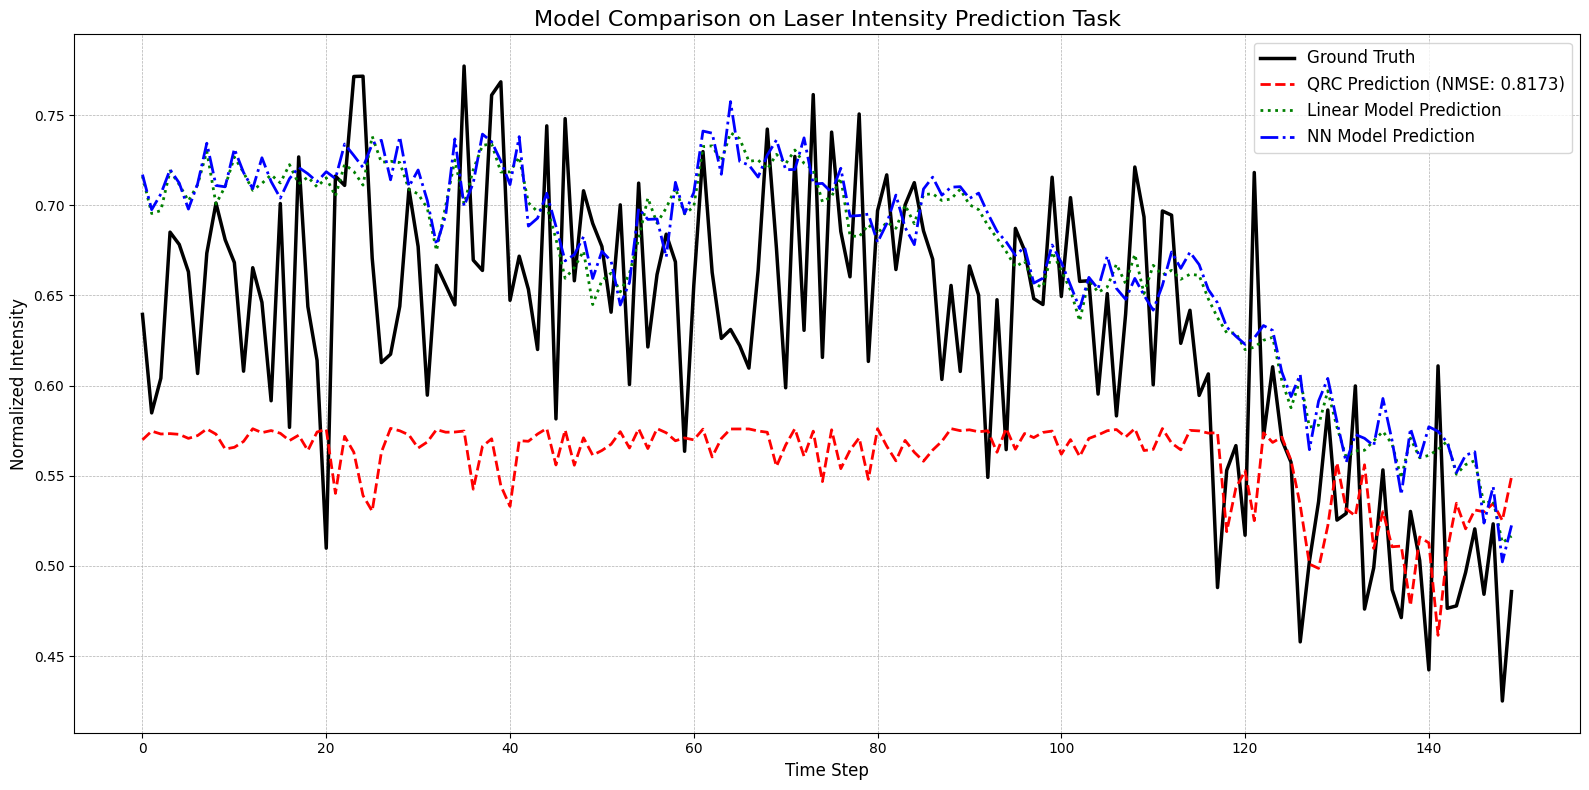

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.sparse import identity, kron, csr_matrix, csc_matrix
from scipy.sparse.linalg import expm_multiply
from scipy.integrate import solve_ivp
import pandas as pd
from tqdm import tqdm

# 1. Atom Positioning with Irregular Spacing
class AtomList:
    def __init__(self, positions):
        """
        positions: List of (x, y) tuples for atom positions
        """
        self.positions = np.array(positions)
        self.n_atoms = len(positions)
        
    def distances(self):
        """Calculate pairwise distances between atoms"""
        dist_matrix = np.zeros((self.n_atoms, self.n_atoms))
        for i in range(self.n_atoms):
            for j in range(i+1, self.n_atoms):
                dist = np.sqrt(np.sum((self.positions[i] - self.positions[j])**2))
                dist_matrix[i, j] = dist
                dist_matrix[j, i] = dist
        return dist_matrix

def generate_chain_lattice(n_sites, scale=10.0):
    """Generate a 1D chain of atoms with uniform spacing"""
    return AtomList([(0, i*scale) for i in range(n_sites)])

def generate_irregular_chain(n_sites, distances):
    """
    Generate a 1D chain with irregular spacing
    distances: List of n_sites-1 distances between adjacent atoms
    """
    if len(distances) != n_sites - 1:
        raise ValueError("Need n_sites-1 distances for n_sites atoms")
        
    positions = [(0, 0)]
    y_pos = 0
    for d in distances:
        y_pos += d
        positions.append((0, y_pos))
        
    return AtomList(positions)

# 2. Time-Dependent Pulse Shaping
class PiecewiseLinear:
    def __init__(self, clocks, values):
        """
        Define a piecewise linear function
        clocks: List of time points
        values: Function values at those time points
        """
        if len(clocks) != len(values):
            raise ValueError("clocks and values must have same length")
            
        self.clocks = np.array(clocks)
        self.values = np.array(values)
        
    def __call__(self, t):
        """Evaluate function at time t"""
        if t <= self.clocks[0]:
            return self.values[0]
        if t >= self.clocks[-1]:
            return self.values[-1]
            
        # Find the appropriate segment
        idx = np.searchsorted(self.clocks, t) - 1
        t0, t1 = self.clocks[idx], self.clocks[idx+1]
        v0, v1 = self.values[idx], self.values[idx+1]
        
        # Linear interpolation
        alpha = (t - t0) / (t1 - t0)
        return v0 + alpha * (v1 - v0)

class PiecewiseConstant:
    def __init__(self, clocks, values):
        """
        Define a piecewise constant function
        clocks: List of time points where function changes
        values: Function values for each interval
        """
        if len(clocks) != len(values) + 1:
            raise ValueError("For piecewise constant, need len(clocks) = len(values) + 1")
            
        self.clocks = np.array(clocks)
        self.values = np.array(values)
        
    def __call__(self, t):
        """Evaluate function at time t"""
        idx = np.searchsorted(self.clocks, t) - 1
        if idx < 0:
            return self.values[0]
        if idx >= len(self.values):
            return self.values[-1]
        return self.values[idx]

# 3. Fixed Operators for Quantum Evolution
def construct_single_site_operator(op, site_index, n_sites):
    """Construct single-site operator at given site"""
    I = csr_matrix(np.eye(2))
    result = csr_matrix(np.eye(1))
    
    for i in range(n_sites):
        if i == site_index:
            result = kron(result, op, format="csr")
        else:
            result = kron(result, I, format="csr")
    
    return result

# 4. Fixed Time-Dependent Rydberg Hamiltonian
class RydbergTimeDependent:
    def __init__(self, atom_list, omega_func, detuning_func, V=1.0, phi_func=None):
        """
        Time-dependent Rydberg Hamiltonian
        atom_list: AtomList object with atom positions
        omega_func: Function of time t returning Rabi frequency (can be scalar or array)
        detuning_func: Function of time t returning detuning (can be scalar or array)
        V: Interaction strength
        phi_func: Function of time t returning phase (optional)
        """
        self.atom_list = atom_list
        self.n_sites = atom_list.n_atoms
        self.omega_func = omega_func
        self.detuning_func = detuning_func
        self.phi_func = phi_func if phi_func is not None else lambda t: 0
        self.V = V
        
        # Precompute distances for Rydberg interaction
        self.distances = atom_list.distances()
        
        # Pauli matrices
        self.sigma_x = csr_matrix(np.array([[0, 1], [1, 0]]))
        self.sigma_y = csr_matrix(np.array([[0, -1j], [1j, 0]]))
        self.sigma_z = csr_matrix(np.array([[1, 0], [0, -1]]))
        self.n_op = csr_matrix(np.array([[0, 0], [0, 1]]))  # |1><1|
        
        # Pre-construct single-site operators to avoid repeated construction
        self.sigma_x_ops = [construct_single_site_operator(self.sigma_x, i, self.n_sites) 
                           for i in range(self.n_sites)]
        self.sigma_y_ops = [construct_single_site_operator(self.sigma_y, i, self.n_sites) 
                           for i in range(self.n_sites)]
        self.sigma_z_ops = [construct_single_site_operator(self.sigma_z, i, self.n_sites) 
                           for i in range(self.n_sites)]
        self.n_ops = [construct_single_site_operator(self.n_op, i, self.n_sites) 
                     for i in range(self.n_sites)]
        
    def get_hamiltonian(self, t):
        """Get Hamiltonian at time t"""
        omega_t = self.omega_func(t)
        detuning_t = self.detuning_func(t)
        phi_t = self.phi_func(t)
        
        # Initialize Hamiltonian
        H = csr_matrix((2**self.n_sites, 2**self.n_sites), dtype=complex)
        
        # Single-site terms
        for i in range(self.n_sites):
            # Get site-specific parameters if provided as arrays
            omega_i = omega_t[i] if isinstance(omega_t, (list, np.ndarray)) and i < len(omega_t) else omega_t
            detuning_i = detuning_t[i] if isinstance(detuning_t, (list, np.ndarray)) and i < len(detuning_t) else detuning_t
            
            # Rabi drive with phase
            if abs(omega_i) > 1e-10:
                cos_phi = np.cos(phi_t)
                sin_phi = np.sin(phi_t)
                H += 0.5 * omega_i * (cos_phi * self.sigma_x_ops[i] + sin_phi * self.sigma_y_ops[i])
            
            # Detuning
            if abs(detuning_i) > 1e-10:
                H += -0.5 * detuning_i * self.sigma_z_ops[i]  # Using -σz/2 convention
        
        # Two-site Rydberg interaction terms (blockade)
        for i in range(self.n_sites):
            for j in range(i+1, self.n_sites):
                dist = self.distances[i, j]
                if dist > 1e-9:  # Avoid division by zero
                    # Rydberg interaction ~ 1/r^6 for van der Waals
                    interaction = self.V / (dist**6)
                    if abs(interaction) > 1e-10:
                        H += interaction * self.n_ops[i] @ self.n_ops[j]
        
        return H

# 5. Enhanced Quantum Evolution with better error handling
class QuantumEvolution:
    def __init__(self, atol=1e-8, rtol=1e-8, use_gpu=True):
        self.atol = atol
        self.rtol = rtol
        self.use_gpu = use_gpu and torch.cuda.is_available()
        self.device = torch.device("cuda" if self.use_gpu else "cpu")
        
    def evolve_state_torch(self, init_state, hamiltonian_func, t_span, t_eval=None):
        """Evolve quantum state using a custom RK4 integrator on GPU."""
        if t_eval is None:
            t_eval = np.linspace(t_span[0], t_span[1], 100)
        
        psi = torch.tensor(init_state.astype(complex), dtype=torch.cfloat, device=self.device)
        states = [psi.cpu().numpy()]
        
        t = t_span[0]
        for i in range(1, len(t_eval)):
            dt = t_eval[i] - t
            H_mid = hamiltonian_func(t + dt/2) # Use midpoint Hamiltonian for RK4
            if hasattr(H_mid, 'toarray'):
                H_mid = H_mid.toarray()
            H_t = torch.tensor(H_mid, dtype=torch.cfloat, device=self.device)

            # RK4 integration
            k1 = -1j * torch.matmul(H_t, psi)
            k2 = -1j * torch.matmul(H_t, psi + 0.5 * dt * k1)
            k3 = -1j * torch.matmul(H_t, psi + 0.5 * dt * k2)
            k4 = -1j * torch.matmul(H_t, psi + dt * k3)
            
            psi = psi + (dt/6) * (k1 + 2*k2 + 2*k3 + k4)
            psi = psi / torch.norm(psi) # Normalize state
            
            t = t_eval[i]
            states.append(psi.cpu().numpy())
        
        return np.array(states)
    
    def evolve_state_ode(self, init_state, hamiltonian_func, t_span, t_eval=None):
        """Evolve quantum state using either GPU or CPU ODE solver."""
        if self.use_gpu:
            return self.evolve_state_torch(init_state, hamiltonian_func, t_span, t_eval)
        else:
            init_state = init_state.flatten().astype(complex)
            def schrodinger_eq(t, psi):
                H_t = hamiltonian_func(t).toarray()
                return -1j * (H_t @ psi)
        
            result = solve_ivp(
                schrodinger_eq, t_span, init_state, t_eval=t_eval,
                method='DOP853', atol=self.atol, rtol=self.rtol
            )
            if not result.success:
                print(f"ODE solver failed: {result.message}")
                return None
            
            states = result.y.T
            norms = np.linalg.norm(states, axis=1, keepdims=True)
            return states / norms

# 6. Enhanced Readout for Quantum States
def construct_pauli_z(qubit_index, num_qubits):
    op = csr_matrix(np.array([[1, 0], [0, -1]]))
    return construct_single_site_operator(op, qubit_index, num_qubits)

def construct_pauli_zz(qubit_i, qubit_j, num_qubits):
    z_i = construct_pauli_z(qubit_i, num_qubits)
    z_j = construct_pauli_z(qubit_j, num_qubits)
    return z_i @ z_j

def expectation(state, operator):
    return np.real(np.vdot(state, operator @ state))

class EnhancedReadout:
    def __init__(self, n_sites, include_zz=True):
        self.n_sites = n_sites
        self.readout_indices = list(range(n_sites))
        self.include_zz = include_zz
        if include_zz:
            self.correlation_pairs = [(i, i+1) for i in range(n_sites-1)]
        else:
            self.correlation_pairs = []
            
    def measure_single_state(self, state, num_qubits):
        features = [expectation(state, construct_pauli_z(idx, num_qubits)) for idx in self.readout_indices]
        if self.include_zz:
            features.extend([expectation(state, construct_pauli_zz(i, j, num_qubits)) for i, j in self.correlation_pairs])
        return features
        
    def measure(self, evolved_results, num_qubits):
        features = []
        for state_history in evolved_results:
            if state_history is None:
                padding_size = len(self.readout_indices) + (len(self.correlation_pairs) if self.include_zz else 0)
                features.append([0] * padding_size)
            else:
                final_state = state_history[-1]
                features.append(self.measure_single_state(final_state, num_qubits))
        return np.array(features)

# 7. Improved QRC with Time-Dependent Hamiltonian
class ImprovedQRC:
    def __init__(self, n_sites=10, encoding_type='global', omega_max=2*np.pi*1.5, V=1.0, 
                 duration=3.5, steps=10, atom_distances=None, use_gpu=True):
        self.n_sites = n_sites
        self.encoding_type = encoding_type
        self.omega_max = omega_max
        self.V = V
        self.duration = duration
        self.steps = steps
        
        if atom_distances is None:
            atom_distances = [8.3, 8.2, 8.2, 8.2, 8.1, 8.8, 8.2, 8.8, 8.8]
            if n_sites > len(atom_distances) + 1:
                atom_distances.extend([np.mean(atom_distances)] * (n_sites - 1 - len(atom_distances)))
            else:
                atom_distances = atom_distances[:n_sites-1]
        self.atoms = generate_irregular_chain(n_sites, atom_distances)
        self.evolution = QuantumEvolution(use_gpu=use_gpu)
        self.readout = EnhancedReadout(n_sites, include_zz=True)
        
    def encode_and_evolve(self, X):
        evolved_states_all = []
        for sample in tqdm(X, desc="Quantum Evolution"):
            init_state = np.zeros(2**self.n_sites, dtype=complex); init_state[0] = 1.0
            
            if self.encoding_type == 'global':
                clocks = np.linspace(0, self.duration, len(sample) + 1)
                values = np.append(sample, sample[-1])
                detuning_func = PiecewiseLinear(clocks, values)
                rabi_ramp = 0.05 * self.duration
                rabi_clocks = [0.0, rabi_ramp, self.duration - rabi_ramp, self.duration]
                rabi_values = [0.0, self.omega_max, self.omega_max, 0.0]
                omega_func = PiecewiseLinear(rabi_clocks, rabi_values)
            else: # 'local' encoding
                detuning_values = np.zeros(self.n_sites)
                detuning_values[:len(sample)] = sample
                detuning_func = lambda t: detuning_values
                omega_func = lambda t: self.omega_max
            
            hamiltonian = RydbergTimeDependent(self.atoms, omega_func, detuning_func, V=self.V)
            t_eval = np.linspace(0, self.duration, self.steps + 1)
            evolved_states = self.evolution.evolve_state_ode(init_state, hamiltonian.get_hamiltonian, (0, self.duration), t_eval)
            evolved_states_all.append(evolved_states)
        
        return self.readout.measure(evolved_states_all, self.n_sites)

# 8. Linear readout layer (using PyTorch)
class LinearReadout(torch.nn.Module):
    def __init__(self, input_size, output_size=1):
        super(LinearReadout, self).__init__()
        self.linear = torch.nn.Linear(input_size, output_size)
    
    def forward(self, x):
        return self.linear(x)

# 9. Data loading and preparation
def load_laser_data(path="laser_train.csv"):
    try:
        df = pd.read_csv(path, header=None, names=["laser"])
        return df["laser"].values / 255.0
    except FileNotFoundError:
        print(f"Warning: Data file '{path}' not found. Generating synthetic data instead.")
        t = np.linspace(0, 100, 2000)
        data = 0.5 + 0.3 * np.sin(t/5) + 0.1 * np.sin(t/2) + 0.05 * np.random.randn(2000)
        return data / np.max(data)

def prepare_time_series(data, window=10):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

# 10. Training function
def train_model(model, X_train, y_train, X_test, y_test, epochs=1000, lr=0.01, use_gpu=True):
    device = torch.device("cuda" if use_gpu and torch.cuda.is_available() else "cpu")
    print(f"Training on device: {device}")
    model.to(device)
    
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1).to(device)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.MSELoss()
    
    for epoch in range(epochs):
        model.train()
        y_pred = model(X_train_tensor)
        loss = criterion(y_pred, y_train_tensor)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        if epoch % 200 == 0:
            model.eval()
            with torch.no_grad():
                y_test_pred = model(X_test_tensor)
                test_loss = criterion(y_test_pred, y_test_tensor)
            print(f'Epoch {epoch}, Train Loss: {loss.item():.6f}, Test Loss: {test_loss.item():.6f}')
    return model

# 11. Main QRC execution function
def run_improved_qrc_experiment(use_gpu=True):
    device = torch.device("cuda" if use_gpu and torch.cuda.is_available() else "cpu")
    data = load_laser_data()
    window = 10
    X, y = prepare_time_series(data, window)
    train_size = int(len(X) * 0.7)
    X_train, y_train = X[:train_size], y[:train_size]
    X_test, y_test = X[train_size:], y[train_size:]
    
    mean_X, std_X = np.mean(X_train), np.std(X_train)
    X_train_scaled = (X_train - mean_X) / std_X * 2.0 * np.pi
    X_test_scaled = (X_test - mean_X) / std_X * 2.0 * np.pi
    
    print("Initializing Improved QRC...")
    qrc = ImprovedQRC(n_sites=10, encoding_type='global', use_gpu=use_gpu)
    
    print("Generating quantum features for training data...")
    X_train_quantum = qrc.encode_and_evolve(X_train_scaled)
    print("Generating quantum features for test data...")
    X_test_quantum = qrc.encode_and_evolve(X_test_scaled)
    
    print("Training readout layer...")
    readout_model = LinearReadout(X_train_quantum.shape[1])
    readout_model = train_model(readout_model, X_train_quantum, y_train, X_test_quantum, y_test, epochs=1000, lr=0.01, use_gpu=use_gpu)
    
    readout_model.eval()
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test_quantum, dtype=torch.float32).to(device)
        y_pred = readout_model(X_test_tensor).cpu().numpy()
    
    test_nmse = np.mean((y_test - y_pred.flatten())**2) / np.var(y_test)
    print(f"\nQRC Test NMSE: {test_nmse:.6f}")
    
    return y_test, y_pred, test_nmse

# 12. Classical baselines for comparison
def run_classical_baselines(X_train, y_train, X_test, y_test):
    print("\n--- Training Classical Linear Model ---")
    linear_model = LinearReadout(X_train.shape[1])
    linear_model = train_model(linear_model, X_train, y_train, X_test, y_test, epochs=2000, lr=0.01, use_gpu=False)
    
    print("\n--- Training Classical Neural Network Model ---")
    nn_model = torch.nn.Sequential(
        torch.nn.Linear(X_train.shape[1], 50), torch.nn.ReLU(),
        torch.nn.Linear(50, 50), torch.nn.ReLU(),
        torch.nn.Linear(50, 1)
    )
    nn_model = train_model(nn_model, X_train, y_train, X_test, y_test, epochs=3000, lr=0.005, use_gpu=False)

    with torch.no_grad():
        linear_pred = linear_model(torch.tensor(X_test, dtype=torch.float32)).numpy()
        nn_pred = nn_model(torch.tensor(X_test, dtype=torch.float32)).numpy()
    
    linear_nmse = np.mean((y_test - linear_pred.flatten())**2) / np.var(y_test)
    nn_nmse = np.mean((y_test - nn_pred.flatten())**2) / np.var(y_test)
    
    print(f"\nLinear Model Test NMSE: {linear_nmse:.6f}")
    print(f"Neural Network Test NMSE: {nn_nmse:.6f}")
    
    return linear_pred, nn_pred

# Main execution block
if __name__ == "__main__":
    use_gpu_flag = torch.cuda.is_available()
    if use_gpu_flag:
        print("GPU is available. Using CUDA for quantum evolution.")
    else:
        print("GPU not available. Running on CPU.")
    
    # Run QRC experiment
    y_test_qrc, y_pred_qrc, nmse_qrc = run_improved_qrc_experiment(use_gpu=use_gpu_flag)
    
    # Run classical baselines on raw data
    data = load_laser_data()
    window = 10
    X, y = prepare_time_series(data, window)
    train_size = int(len(X) * 0.7)
    X_train, y_train, X_test, y_test_classical = X[:train_size], y[:train_size], X[train_size:], y[train_size:]
    
    linear_pred, nn_pred = run_classical_baselines(X_train, y_train, X_test, y_test_classical)
    
    # Final Comparison Plot
    plt.figure(figsize=(16, 8))
    plot_range = slice(50, 200)
    plt.plot(y_test_qrc[plot_range], 'k-', label='Ground Truth', linewidth=2.5)
    plt.plot(y_pred_qrc.flatten()[plot_range], 'r--', label=f'QRC Prediction (NMSE: {nmse_qrc:.4f})', linewidth=2)
    plt.plot(linear_pred.flatten()[plot_range], 'g:', label='Linear Model Prediction', linewidth=2)
    plt.plot(nn_pred.flatten()[plot_range], 'b-.', label='NN Model Prediction', linewidth=2)
    plt.title('Model Comparison on Laser Intensity Prediction Task', fontsize=16)
    plt.xlabel('Time Step', fontsize=12)
    plt.ylabel('Normalized Intensity', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()